In [ ]:
!pip install rasterio folium geopandas shapely plotly kagglehub #necessary imports, some not present in colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 68.6 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import rasterio
from rasterio.plot import show
import folium
from folium.plugins import MarkerCluster
import geopandas as gpd
from shapely.geometry import Point
import glob
import cv2
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import kagglehub
import zipfile
import shutil
from datetime import datetime
import re

In [ ]:
# Set up the environment
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Download the MARIDA dataset from the kaggle
print("Downloading MARIDA dataset from Kaggle...")
path = kagglehub.dataset_download("anangfath/marida-marine-debrish-dataset")
print(f"Path to dataset files: {path}")

100%|██████████| 1.08G/1.08G [00:15<00:00, 73.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anangfath/marida-marine-debrish-dataset/versions/1


In [ ]:
# Extract the dataset as it's in a zip file
if os.path.exists(f"{path}/marida.zip"):
    print("Extracting MARIDA dataset...")
    with zipfile.ZipFile(f"{path}/marida.zip", 'r') as zip_ref:
        zip_ref.extractall(path)
    print("Dataset extracted!")

# Defining our base directory
base_dir = path

# Create a directory for processed data
processed_dir = os.path.join(base_dir, "processed")
os.makedirs(processed_dir, exist_ok=True)

In [ ]:
# Define class names from the MARIDA repo
class_mapping = {
    1: 'Marine Debris',
    2: 'Dense Sargassum',
    3: 'Sparse Sargassum',
    4: 'Natural Organic Material',
    5: 'Ship',
    6: 'Clouds',
    7: 'Marine Water',
    8: 'Sediment-Laden Water',
    9: 'Foam',
    10: 'Turbid Water',
    11: 'Shallow Water',
    12: 'Waves',
    13: 'Cloud Shadows',
    14: 'Wakes',
    15: 'Mixed Water'
}

In [ ]:
# Define color mapping for visualization (used Deep seek for this)
color_mapping = {
    1: (255, 0, 0),      # Marine Debris - Red
    2: (0, 128, 0),      # Dense Sargassum - Green
    3: (144, 238, 144),  # Sparse Sargassum - Light Green
    4: (139, 69, 19),    # Natural Organic Material - Brown
    5: (128, 128, 128),  # Ship - Gray
    6: (255, 255, 255),  # Clouds - White
    7: (0, 0, 255),      # Marine Water - Blue
    8: (210, 180, 140),  # Sediment-Laden Water - Tan
    9: (255, 255, 224),  # Foam - Light Yellow
    10: (64, 224, 208),  # Turbid Water - Turquoise
    11: (176, 224, 230), # Shallow Water - Powder Blue
    12: (0, 191, 255),   # Waves - Deep Sky Blue
    13: (105, 105, 105), # Cloud Shadows - Dim Gray
    14: (220, 220, 220), # Wakes - Gainsboro
    15: (70, 130, 180)   # Mixed Water - Steel Blue
}

In [ ]:
def analyze_dataset_structure():
    """Analyze the dataset structure and print basic statistics"""
    # Path to patches directory
    patches_dir = os.path.join(base_dir, "patches")

    if not os.path.exists(patches_dir):
        print(f"Error: Patches directory not found at {patches_dir}")
        return None

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    print(f"Total number of S2 date-tile directories: {len(s2_dirs)}")

    # Count different types of files
    image_count = 0
    mask_count = 0
    conf_count = 0

    # Extract information from filenames
    tiles = []
    dates = []
    locations = []

    # Extract date and tile information
    for s2_dir in tqdm(s2_dirs, desc="Analyzing directories"):
        dir_path = os.path.join(patches_dir, s2_dir)
        files = os.listdir(dir_path)

        # Count file types
        images = [f for f in files if not f.endswith('_cl.tif') and not f.endswith('_conf.tif') and f.endswith('.tif')]
        masks = [f for f in files if f.endswith('_cl.tif')]
        confs = [f for f in files if f.endswith('_conf.tif')]

        image_count += len(images)
        mask_count += len(masks)
        conf_count += len(confs)

        """ Extract date and tile information - FIXED PATTERN MATCHING
            The directory structure might be different than expected
            Handle the case when dates list might be empty """
        try:
            # Try different pattern formats that might exist in your data
            # Original pattern: r'S2_(\d{8})_(\w+)'
            # Modified patterns:
            match = re.match(r'S2_(\d{8})_(\w+)', s2_dir)  # Original pattern
            if not match:
                match = re.match(r'(\d{8})_(\w+)', s2_dir)  # Try without 'S2_'
            if not match:
                match = re.match(r'S2_(\d{8})', s2_dir)  # Try without tile information
            if not match:
                match = re.match(r'(\d{8})', s2_dir)  # Try only date

            if match:
                date_str = match.group(1)  # Always get the first group (date)
                date = datetime.strptime(date_str, '%Y%m%d')
                dates.append(date)

                if len(match.groups()) > 1:
                    tile = match.group(2)  # Get tile information if available
                    tiles.append(tile)

        except (ValueError, IndexError) as e:
            print(f"Warning: Could not extract date or tile from '{s2_dir}': {e}")

    # Check if dates list is still empty after trying different patterns
    if not dates:
        print("Warning: Could not extract dates from directory names after trying different patterns")
        # Print directory names for debugging
        print(f"Sample directory names: {s2_dirs[:5] if len(s2_dirs) >= 5 else s2_dirs}")
        print("Date range: Unknown")
    else:
        print(f"Date range: {min(dates).strftime('%Y-%m-%d')} to {max(dates).strftime('%Y-%m-%d')}")


    print(f"Total number of image patches: {image_count}")
    print(f"Total number of classification masks: {mask_count}")
    print(f"Total number of confidence level masks: {conf_count}")

    # Analyze train/val/test splits
    splits_dir = os.path.join(base_dir, "splits")
    if os.path.exists(splits_dir):
        split_files = [f for f in os.listdir(splits_dir) if f.endswith('.txt')]
        print("\nTrain/Val/Test splits:")
        for split_file in split_files:
            with open(os.path.join(splits_dir, split_file), 'r') as f:
                samples = f.readlines()
            print(f"  {split_file}: {len(samples)} samples")

    # Analyze labels mapping for multi-label classification
    labels_mapping_file = os.path.join(base_dir, "labels_mapping.txt")
    if os.path.exists(labels_mapping_file):
        with open(labels_mapping_file, 'r') as f:
            label_lines = f.readlines()
        print(f"\nMulti-label classification mapping: {len(label_lines)} entries")

    return {
        'image_count': image_count,
        'mask_count': mask_count,
        'conf_count': conf_count,
        'date_range': (min(dates), max(dates)) if dates else (None, None) # Handle empty dates
    }

dataset_stats = analyze_dataset_structure()

Total number of S2 date-tile directories: 63


Analyzing directories:   0%|          | 0/63 [00:00<?, ?it/s]

Sample directory names: ['S2_15-10-20_18QYF', 'S2_29-12-20_18QYF', 'S2_3-1-21_18QYF', 'S2_29-11-20_18QYF', 'S2_25-5-19_48MXU']
Date range: Unknown
Total number of image patches: 1381
Total number of classification masks: 1381
Total number of confidence level masks: 1381

Train/Val/Test splits:
  val_X.txt: 328 samples
  train_X.txt: 694 samples
  test_X.txt: 359 samples

Multi-label classification mapping: 1 entries


Analyzing class distribution:   0%|          | 0/50 [00:00<?, ?it/s]

Class distribution (based on 50 random samples):
  8: Sediment-Laden Water - 0.37%
  7: Marine Water - 0.16%
  10: Turbid Water - 0.15%
  6: Clouds - 0.13%
  11: Shallow Water - 0.02%
  13: Cloud Shadows - 0.01%
  14: Wakes - 0.01%
  12: Waves - 0.01%
  5: Ship - 0.01%
  1: Marine Debris - 0.00%
  2: Dense Sargassum - 0.00%
  3: Sparse Sargassum - 0.00%
  9: Foam - 0.00%
  4: Natural Organic Material - 0.00%
  15: Mixed Water - 0.00%


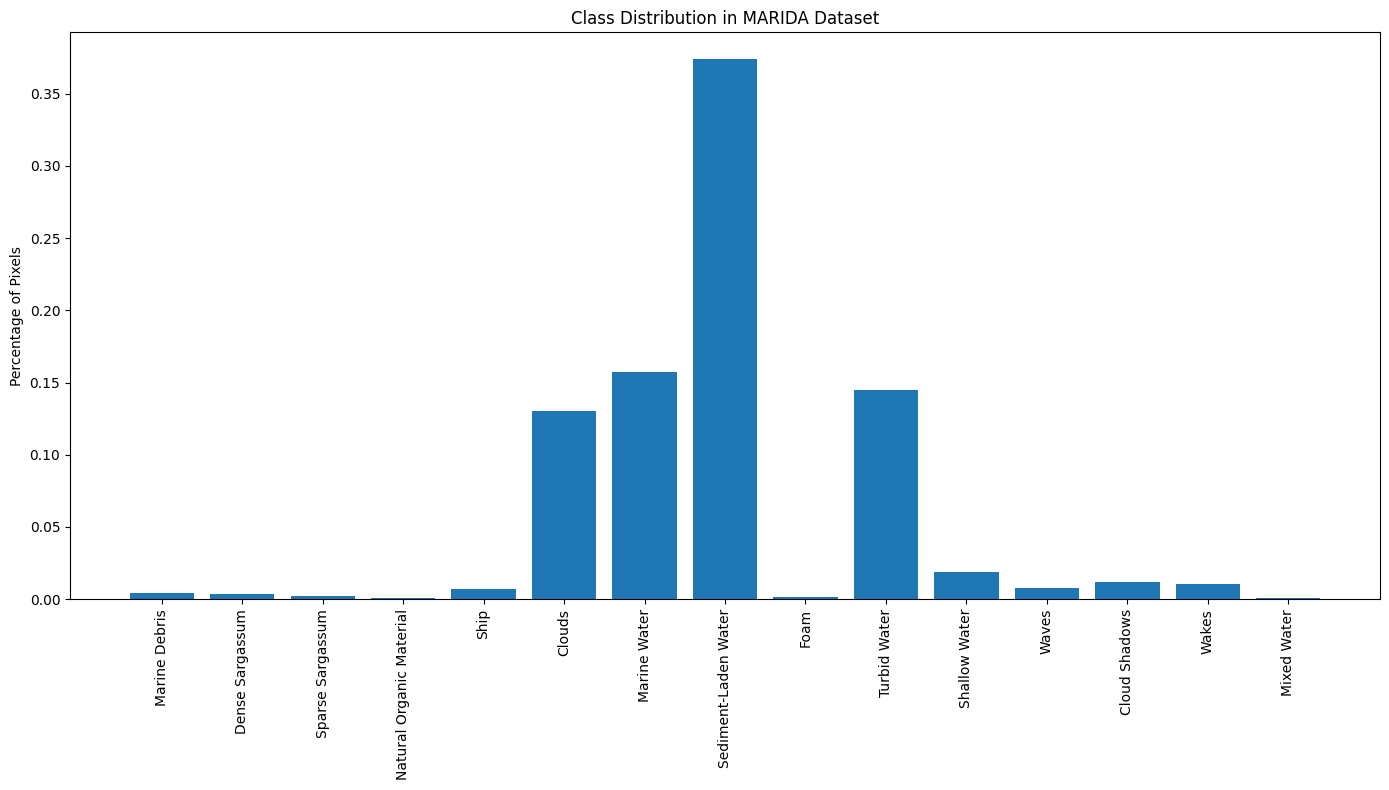


Debris vs. Non-debris:
  Marine Debris: 0.00%
  Non-debris: 0.87%


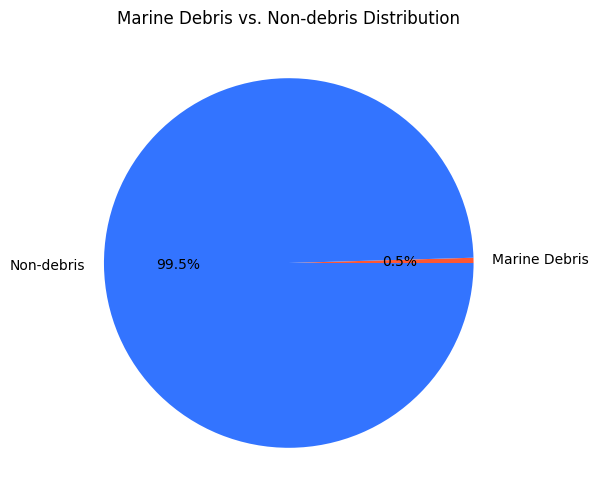

In [ ]:
# Class Distribution Analysis

def analyze_class_distribution(sample_size=50):
    """Analyze the distribution of classes in the dataset"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize class counts
    class_counts = {i: 0 for i in range(1, 16)}
    total_pixels = 0

    for s2_dir in tqdm(s2_dirs_sample, desc="Analyzing class distribution"):
        dir_path = os.path.join(patches_dir, s2_dir)
        mask_files = [f for f in os.listdir(dir_path) if f.endswith('_cl.tif')]

        for mask_file in mask_files:
            mask_path = os.path.join(dir_path, mask_file)
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)

                # Count class pixels
                for class_id in range(1, 16):
                    class_counts[class_id] += np.sum(mask_data == class_id)

                total_pixels += mask_data.size

    # Calculate percentages
    class_percentages = {class_id: count / total_pixels * 100
                         for class_id, count in class_counts.items()}

    # Print results
    print(f"Class distribution (based on {sample_size} random samples):")
    for class_id, percentage in sorted(class_percentages.items(), key=lambda x: x[1], reverse=True):
        print(f"  {class_id}: {class_mapping[class_id]} - {percentage:.2f}%")

    # Plot class distribution
    plt.figure(figsize=(14, 8))
    plt.bar(
        [class_mapping[i] for i in range(1, 16)],
        [class_percentages[i] for i in range(1, 16)]
    )
    plt.xticks(rotation=90)
    plt.ylabel("Percentage of Pixels")
    plt.title("Class Distribution in MARIDA Dataset")
    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "class_distribution.png"))
    plt.show()

    # Calculate debris vs non-debris
    debris_percentage = class_percentages[1]
    non_debris_percentage = sum([p for i, p in class_percentages.items() if i != 1])

    print(f"\nDebris vs. Non-debris:")
    print(f"  Marine Debris: {debris_percentage:.2f}%")
    print(f"  Non-debris: {non_debris_percentage:.2f}%")

    # Plot debris vs non-debris
    plt.figure(figsize=(10, 6))
    plt.pie([debris_percentage, non_debris_percentage],
            labels=['Marine Debris', 'Non-debris'],
            autopct='%1.1f%%',
            colors=['#FF5733', '#3374FF'])
    plt.title("Marine Debris vs. Non-debris Distribution")
    plt.savefig(os.path.join(processed_dir, "debris_vs_non_debris.png"))
    plt.show()

    return class_percentages

class_distribution = analyze_class_distribution()

Extracting spectral signatures:   0%|          | 0/20 [00:00<?, ?it/s]

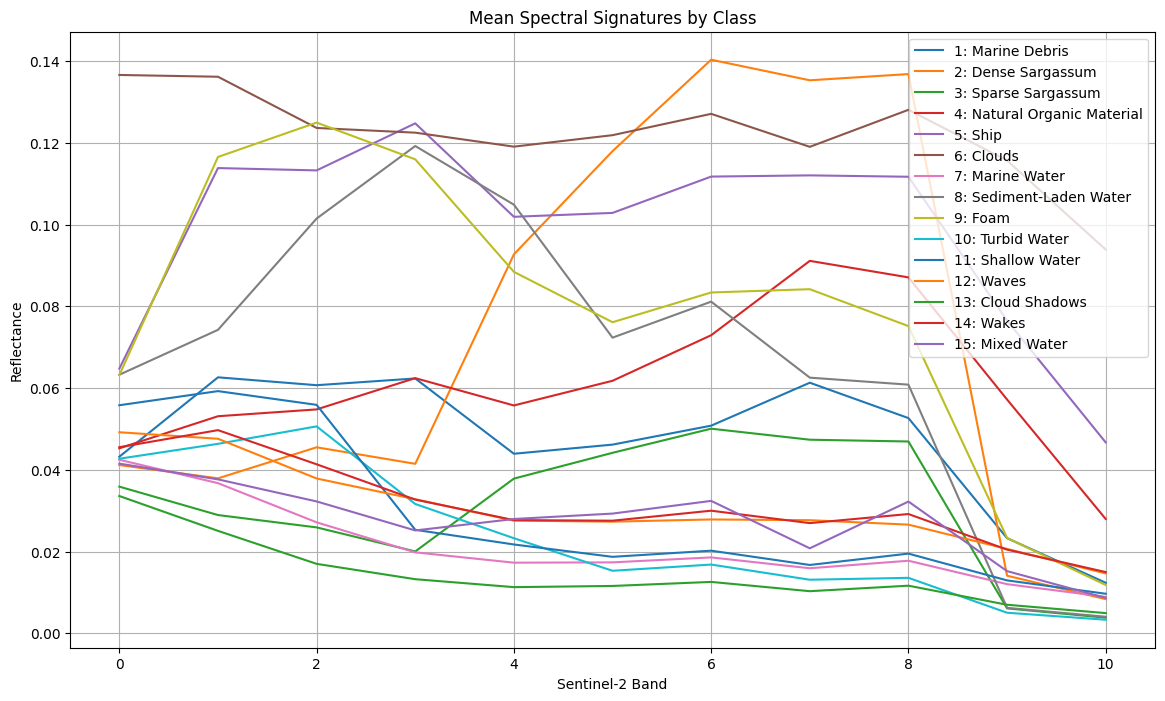

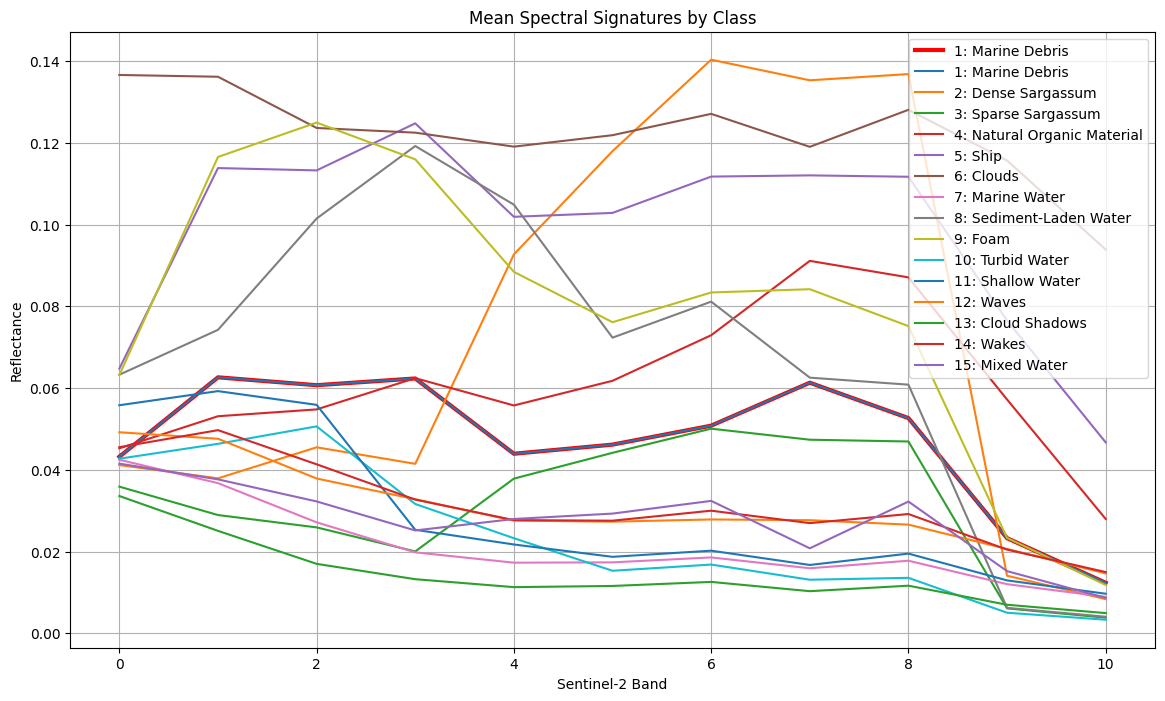

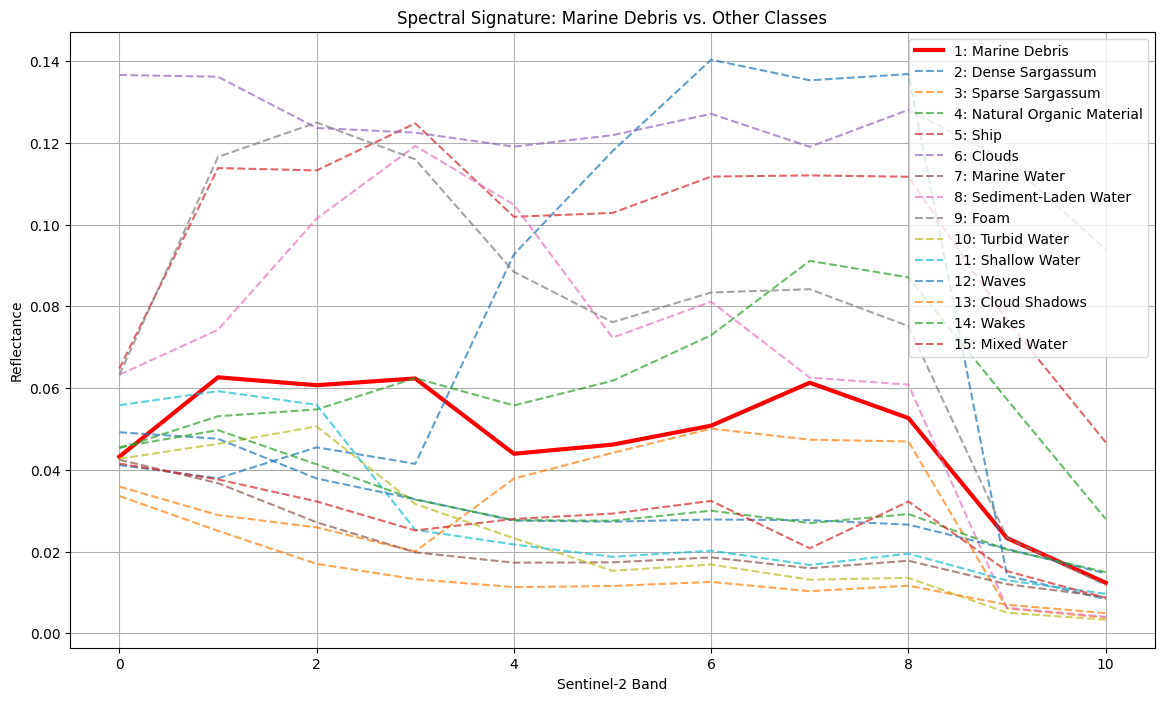

In [ ]:
# Spectral Analysis

def extract_spectral_signatures(sample_size=20):
    """Extract spectral signatures for different classes"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize spectral signatures dictionary
    spectral_signatures = {class_id: [] for class_id in range(1, 16)}

    for s2_dir in tqdm(s2_dirs_sample, desc="Extracting spectral signatures"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path) if not f.endswith('_cl.tif') and not f.endswith('_conf.tif') and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # For each class, extract spectral signatures
                for class_id in range(1, 16):
                    class_pixels = np.where(mask_data == class_id)

                    if len(class_pixels[0]) > 0:
                        # Sample up to 100 pixels per class per image
                        sample_indices = np.random.choice(len(class_pixels[0]),
                                                          min(100, len(class_pixels[0])),
                                                          replace=False)

                        for idx in sample_indices:
                            pixel_y, pixel_x = class_pixels[0][idx], class_pixels[1][idx]
                            spectral_signature = img_data[:, pixel_y, pixel_x]
                            spectral_signatures[class_id].append(spectral_signature)

    # Calculate mean spectral signatures
    mean_signatures = {}
    for class_id, signatures in spectral_signatures.items():
        if signatures:
            mean_signatures[class_id] = np.mean(signatures, axis=0)

    # Plot mean spectral signatures
    plt.figure(figsize=(14, 8))

    for class_id, signature in mean_signatures.items():
        plt.plot(signature, label=f"{class_id}: {class_mapping[class_id]}")

    plt.xlabel("Sentinel-2 Band")
    plt.ylabel("Reflectance")
    plt.title("Mean Spectral Signatures by Class")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "spectral_signatures.png"))
    plt.show()

    # Focus on debris vs other classes
    plt.figure(figsize=(14, 8))

    # Plot debris
    if 1 in mean_signatures:
        plt.plot(mean_signatures[1], 'r-', linewidth=3, label=f"1: {class_mapping[1]}")

    for class_id, signature in mean_signatures.items():
        plt.plot(signature, label=f"{class_id}: {class_mapping[class_id]}")

    plt.xlabel("Sentinel-2 Band")
    plt.ylabel("Reflectance")
    plt.title("Mean Spectral Signatures by Class")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "spectral_signatures.png"))
    plt.show()

    # Focus on debris vs other classes
    plt.figure(figsize=(14, 8))

    # Plot debris
    if 1 in mean_signatures:
        plt.plot(mean_signatures[1], 'r-', linewidth=3, label=f"1: {class_mapping[1]}")

    # Plot other classes
    for class_id, signature in mean_signatures.items():
        if class_id != 1:  # Skip debris
            plt.plot(signature, '--', alpha=0.7, label=f"{class_id}: {class_mapping[class_id]}")

    plt.xlabel("Sentinel-2 Band")
    plt.ylabel("Reflectance")
    plt.title("Spectral Signature: Marine Debris vs. Other Classes")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "debris_vs_others_spectral.png"))
    plt.show()

    return mean_signatures

# Execute spectral analysis
mean_spectral_signatures = extract_spectral_signatures()

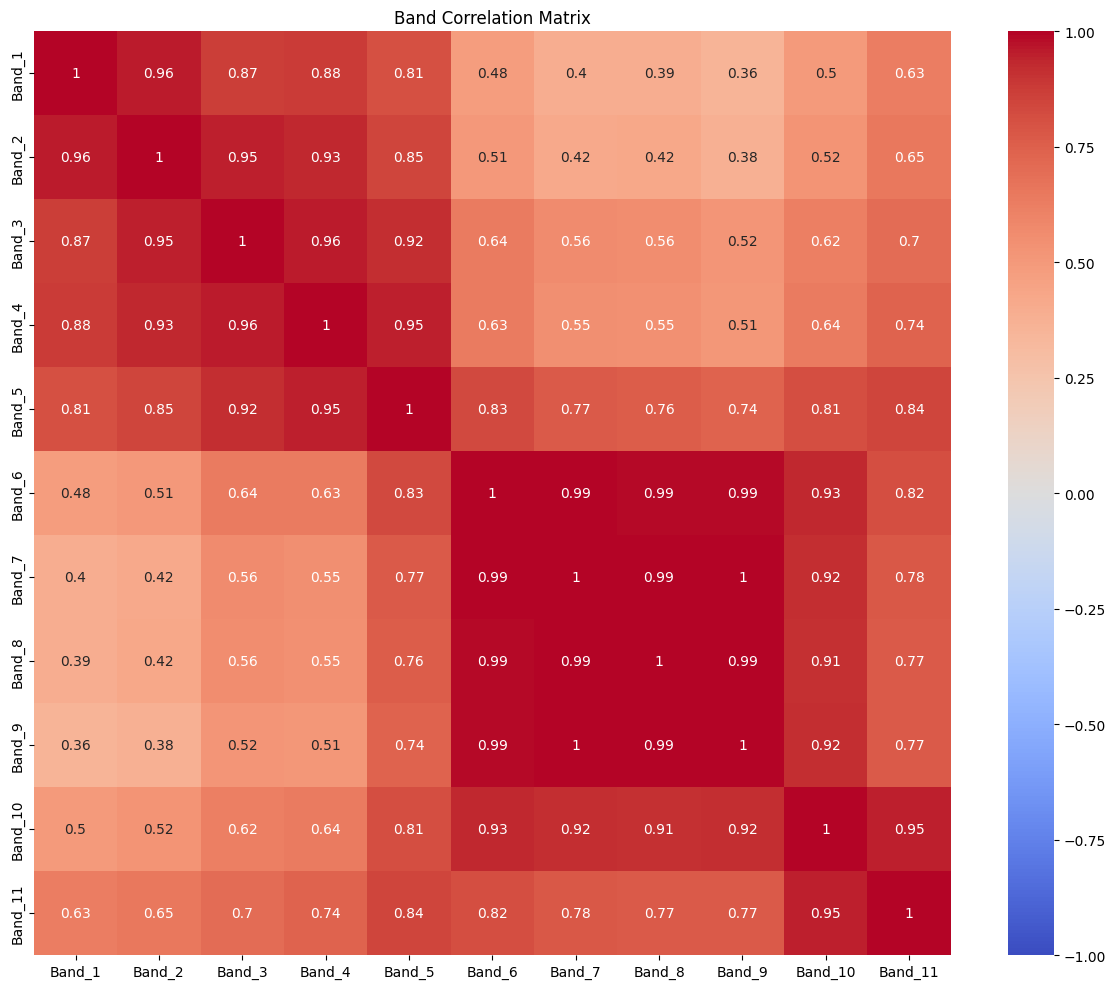

Highly correlated band pairs (|r| > 0.8):
  Band_7 and Band_9: r = 0.997
  Band_7 and Band_8: r = 0.995
  Band_8 and Band_9: r = 0.994
  Band_6 and Band_7: r = 0.993
  Band_6 and Band_8: r = 0.989
  Band_6 and Band_9: r = 0.986
  Band_1 and Band_2: r = 0.959
  Band_3 and Band_4: r = 0.958
  Band_4 and Band_5: r = 0.950
  Band_10 and Band_11: r = 0.950
  Band_2 and Band_3: r = 0.946
  Band_6 and Band_10: r = 0.932
  Band_2 and Band_4: r = 0.930
  Band_7 and Band_10: r = 0.916
  Band_3 and Band_5: r = 0.916
  Band_9 and Band_10: r = 0.915
  Band_8 and Band_10: r = 0.913
  Band_1 and Band_4: r = 0.877
  Band_1 and Band_3: r = 0.869
  Band_2 and Band_5: r = 0.851
  Band_5 and Band_11: r = 0.844
  Band_5 and Band_6: r = 0.832
  Band_6 and Band_11: r = 0.819
  Band_5 and Band_10: r = 0.813
  Band_1 and Band_5: r = 0.812


In [ ]:
# Band Correlation Analysis

def analyze_band_correlations(sample_size=20):
    """Analyze correlations between spectral bands"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize band data collection
    band_data = []

    for s2_dir in tqdm(s2_dirs_sample, desc="Collecting band data"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image files
        image_files = [f for f in os.listdir(dir_path)
                     if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                     and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)

            with rasterio.open(image_path) as src:
                img_data = src.read()
                num_bands = img_data.shape[0]

                # Flatten spatial dimensions, keep band dimension
                img_flat = img_data.reshape(num_bands, -1)

                # Sample pixels (to avoid memory issues)
                num_pixels = img_flat.shape[1]
                sample_indices = np.random.choice(num_pixels, min(1000, num_pixels), replace=False)
                img_sample = img_flat[:, sample_indices]

                # Transpose to have bands as columns
                band_data.append(img_sample.T)

    # Combine all samples
    band_data_combined = np.vstack(band_data)

    # Create DataFrame for correlation analysis
    band_df = pd.DataFrame(band_data_combined,
                          columns=[f"Band_{i+1}" for i in range(band_data_combined.shape[1])])

    # Calculate correlation matrix
    corr_matrix = band_df.corr()

    # Plot correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Band Correlation Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "band_correlation.png"))
    plt.show()

    # Identify highly correlated bands
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                high_corr_pairs.append((
                    corr_matrix.columns[i],
                    corr_matrix.columns[j],
                    corr_matrix.iloc[i, j]
                ))

    if high_corr_pairs:
        print("Highly correlated band pairs (|r| > 0.8):")
        for band1, band2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
            print(f"  {band1} and {band2}: r = {corr:.3f}")
    else:
        print("No highly correlated band pairs found (|r| > 0.8).")

    return corr_matrix

# Execute band correlation analysis
band_correlations = analyze_band_correlations()

In [ ]:
# Spectral Indices Calculation

def calculate_and_visualize_indices(sample_size=10):
    """Calculate and visualize spectral indices for marine debris detection"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    """ Define band indices for common Sentinel-2 bands
        Assuming the spectral bands are in this order:
        B2 (Blue), B3 (Green), B4 (Red), B5 (Red Edge 1), B6 (Red Edge 2),
        B7 (Red Edge 3), B8 (NIR), B8A (NIR narrow), B11 (SWIR 1), B12 (SWIR 2)"""
    blue_idx = 0    # B2
    green_idx = 1   # B3
    red_idx = 2     # B4
    nir_idx = 6     # B8
    swir1_idx = 8   # B11
    swir2_idx = 9   # B12

    for s2_dir in tqdm(s2_dirs_sample, desc="Processing spectral indices"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path)
                     if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                     and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # Get metadata for saving indices
                meta = img_src.meta.copy()
                meta.update(count=1)

                # Extract specific bands
                try:
                    blue = img_data[blue_idx]
                    green = img_data[green_idx]
                    red = img_data[red_idx]
                    nir = img_data[nir_idx]
                    swir1 = img_data[swir1_idx]
                    swir2 = img_data[swir2_idx]
                except IndexError:
                    print(f"  Warning: Not all required bands are available in {image_file}")
                    continue

                # Calculate spectral indices with epsilon to avoid division by zero
                eps = 1e-8

                # NDVI - Normalized Difference Vegetation Index
                ndvi = (nir - red) / (nir + red + eps)

                # NDWI - Normalized Difference Water Index (McFeeters)
                ndwi = (green - nir) / (green + nir + eps)

                # MNDWI - Modified Normalized Difference Water Index
                mndwi = (green - swir1) / (green + swir1 + eps)

                # AWEI - Automated Water Extraction Index
                awei = 4 * (green - swir1) - (0.25 * nir + 2.75 * swir2)

                # FDI - Floating Debris Index
                fdi = nir - (red + (nir - red) * ((swir1 - red) / (nir - red + eps)))

                # Calculate index for detecting plastic specifically
                # PPI - Plastic Presence Index (Custom index)
                ppi = (swir1 - nir) / (swir1 + nir + eps)

                # Save directories for indices
                indices_dir = os.path.join(processed_dir, "indices", s2_dir)
                os.makedirs(indices_dir, exist_ok=True)

                # Display RGB and indices for a sample image
                if np.random.random() < 0.3:  # Only plot ~30% of processed images
                    fig, axs = plt.subplots(2, 4, figsize=(18, 10))

                    # RGB composite
                    rgb = np.stack([red, green, blue], axis=0)
                    rgb = np.transpose(rgb, (1, 2, 0))
                    # Normalize for display
                    rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb) + eps)

                    axs[0, 0].imshow(rgb_norm)
                    axs[0, 0].set_title("RGB Composite")

                    # Create a mask for marine debris
                    debris_mask = np.zeros_like(mask_data)
                    debris_mask[mask_data == 1] = 1

                    # Display mask
                    axs[0, 1].imshow(debris_mask, cmap='binary_r')
                    axs[0, 1].set_title("Marine Debris Mask")

                    # Display indices
                    axs[0, 2].imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
                    axs[0, 2].set_title("NDVI")

                    axs[0, 3].imshow(ndwi, cmap='Blues', vmin=-1, vmax=1)
                    axs[0, 3].set_title("NDWI")

                    axs[1, 0].imshow(mndwi, cmap='Blues', vmin=-1, vmax=1)
                    axs[1, 0].set_title("MNDWI")

                    axs[1, 1].imshow(awei, cmap='viridis')
                    axs[1, 1].set_title("AWEI")

                    axs[1, 2].imshow(fdi, cmap='plasma')
                    axs[1, 2].set_title("FDI")

                    axs[1, 3].imshow(ppi, cmap='RdBu', vmin=-1, vmax=1)
                    axs[1, 3].set_title("PPI (Plastic)")

                    plt.tight_layout()
                    plt.savefig(os.path.join(indices_dir, f"{image_file.replace('.tif', '_indices.png')}"))
                    plt.show()

                    # Save indices as GeoTIFF
                    indices_stack = np.stack([ndvi, ndwi, mndwi, awei, fdi, ppi])
                    meta.update(count=6)

                    with rasterio.open(
                        os.path.join(indices_dir, f"{image_file.replace('.tif', '_indices.tif')}"),
                        'w',
                        **meta
                    ) as dst:
                        dst.write(indices_stack)

    print("Spectral indices calculated and saved.")

# Execute spectral indices calculation
calculate_and_visualize_indices()

Analyzing confidence levels:   0%|          | 0/30 [00:00<?, ?it/s]

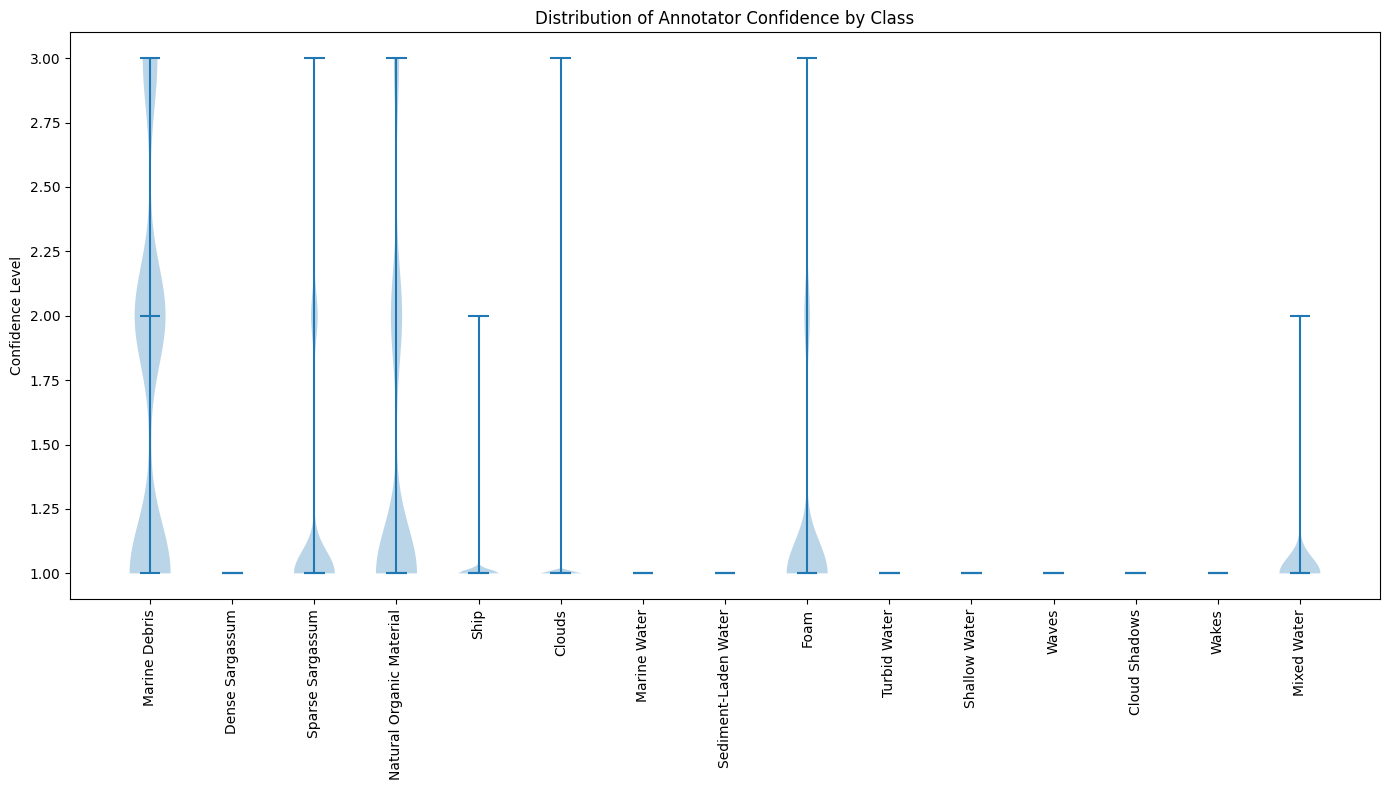

Annotator confidence statistics by class:
  1: Marine Debris
    Mean: 1.70
    Median: 2.00
    Std Dev: 0.74
    Range: 1.00 - 3.00
  4: Natural Organic Material
    Mean: 1.38
    Median: 1.00
    Std Dev: 0.65
    Range: 1.00 - 3.00
  9: Foam
    Mean: 1.16
    Median: 1.00
    Std Dev: 0.41
    Range: 1.00 - 3.00
  3: Sparse Sargassum
    Mean: 1.16
    Median: 1.00
    Std Dev: 0.38
    Range: 1.00 - 3.00
  15: Mixed Water
    Mean: 1.03
    Median: 1.00
    Std Dev: 0.16
    Range: 1.00 - 2.00
  5: Ship
    Mean: 1.00
    Median: 1.00
    Std Dev: 0.06
    Range: 1.00 - 2.00
  6: Clouds
    Mean: 1.00
    Median: 1.00
    Std Dev: 0.03
    Range: 1.00 - 3.00
  2: Dense Sargassum
    Mean: 1.00
    Median: 1.00
    Std Dev: 0.00
    Range: 1.00 - 1.00
  7: Marine Water
    Mean: 1.00
    Median: 1.00
    Std Dev: 0.00
    Range: 1.00 - 1.00
  8: Sediment-Laden Water
    Mean: 1.00
    Median: 1.00
    Std Dev: 0.00
    Range: 1.00 - 1.00
  10: Turbid Water
    Mean: 1.00
    Medi

In [ ]:
# Confidence Level Analysis

def analyze_confidence_levels(sample_size=30):
    """Analyze annotator confidence levels for different classes"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize confidence data
    class_confidence = {class_id: [] for class_id in range(1, 16)}

    for s2_dir in tqdm(s2_dirs_sample, desc="Analyzing confidence levels"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find confidence mask files
        conf_files = [f for f in os.listdir(dir_path) if f.endswith('_conf.tif')]

        for conf_file in conf_files:
            conf_path = os.path.join(dir_path, conf_file)
            mask_file = conf_file.replace('_conf.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open confidence and class masks
            with rasterio.open(conf_path) as conf_src, rasterio.open(mask_path) as mask_src:
                conf_data = conf_src.read(1)
                mask_data = mask_src.read(1)

                # For each class, extract confidence levels
                for class_id in range(1, 16):
                    class_pixels = np.where(mask_data == class_id)

                    if len(class_pixels[0]) > 0:
                        # Get confidence values for this class
                        class_conf = conf_data[class_pixels]
                        class_confidence[class_id].extend(class_conf.flatten())

    # Calculate confidence statistics
    confidence_stats = {}
    for class_id, conf_values in class_confidence.items():
        if conf_values:
            confidence_stats[class_id] = {
                'mean': np.mean(conf_values),
                'median': np.median(conf_values),
                'std': np.std(conf_values),
                'min': np.min(conf_values),
                'max': np.max(conf_values)
            }

    # Plot confidence distributions
    plt.figure(figsize=(14, 8))

    # Only include classes with data
    valid_classes = [class_id for class_id, values in class_confidence.items() if values]

    # Create violin plot
    violin_data = [class_confidence[class_id] for class_id in valid_classes]
    violin_labels = [class_mapping[class_id] for class_id in valid_classes]

    plt.violinplot(violin_data, showmedians=True)
    plt.xticks(range(1, len(valid_classes) + 1), violin_labels, rotation=90)
    plt.ylabel("Confidence Level")
    plt.title("Distribution of Annotator Confidence by Class")
    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "confidence_distribution.png"))
    plt.show()

    # Print results
    print("Annotator confidence statistics by class:")
    for class_id, stats in sorted(confidence_stats.items(), key=lambda x: x[1]['mean'], reverse=True):
        print(f"  {class_id}: {class_mapping[class_id]}")
        print(f"    Mean: {stats['mean']:.2f}")
        print(f"    Median: {stats['median']:.2f}")
        print(f"    Std Dev: {stats['std']:.2f}")
        print(f"    Range: {stats['min']:.2f} - {stats['max']:.2f}")

    # Focus on marine debris confidence
    if 1 in confidence_stats:
        print("\nMarine Debris confidence statistics:")
        stats = confidence_stats[1]
        print(f"  Mean: {stats['mean']:.2f}")
        print(f"  Median: {stats['median']:.2f}")
        print(f"  Std Dev: {stats['std']:.2f}")
        print(f"  Range: {stats['min']:.2f} - {stats['max']:.2f}")

    return confidence_stats

# Execute confidence level analysis
confidence_statistics = analyze_confidence_levels()

Extracting temporal data:   0%|          | 0/63 [00:00<?, ?it/s]

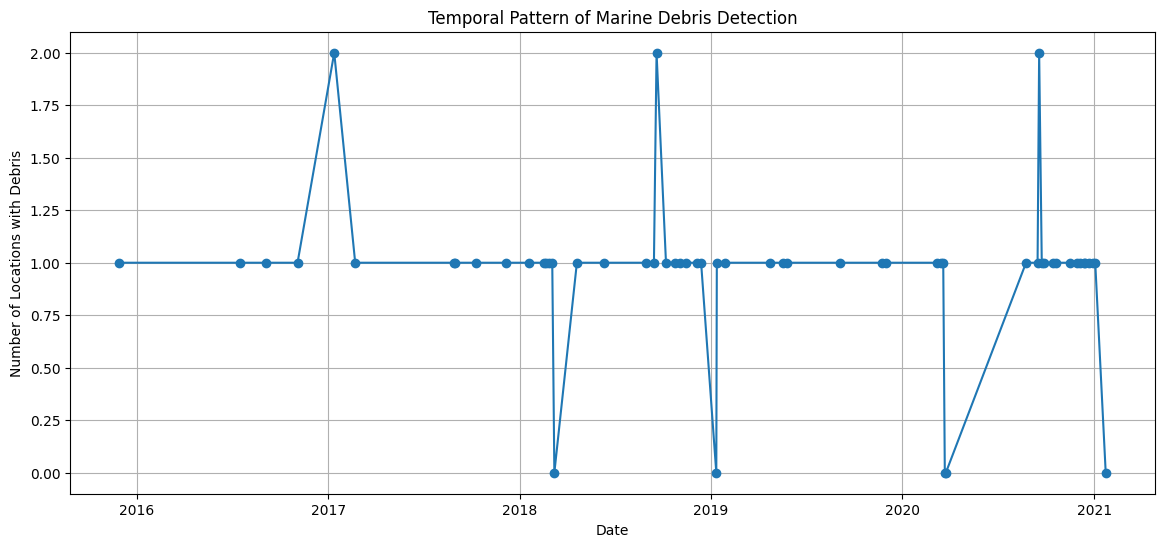

In [ ]:
# Temporal Analysis

def analyze_temporal_patterns():
    """Analyze temporal patterns in debris occurrence"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Extract date information and debris presence
    dates = []
    debris_presence = []

    for s2_dir in tqdm(s2_dirs, desc="Extracting temporal data"):
        # Extract date from directory name using a more flexible pattern
        try:
            # Try different pattern formats that might exist in your data
            match = re.search(r'S2_(\d{1,2}-\d{1,2}-\d{2})_(\w+)', s2_dir)  # dd-mm-yy format
            if not match:
                match = re.search(r'S2_(\d{1,2}-\d{1,2}-\d{4})_(\w+)', s2_dir)  # dd-mm-yyyy format
            if not match:
                match = re.search(r'S2_(\d{8})_(\w+)', s2_dir)  # yyyymmdd format (original)

            if match:
                date_str = match.group(1)

                # Handle different date formats
                try:
                    date = datetime.strptime(date_str, '%d-%m-%y')
                except ValueError:
                    try:
                        date = datetime.strptime(date_str, '%d-%m-%Y')
                    except ValueError:
                        date = datetime.strptime(date_str, '%Y%m%d')

                dates.append(date)

            # Check for debris presence in any image within the directory
            dir_path = os.path.join(patches_dir, s2_dir)
            mask_files = [f for f in os.listdir(dir_path) if f.endswith('_cl.tif')]

            has_debris = False
            for mask_file in mask_files:
                mask_path = os.path.join(dir_path, mask_file)
                with rasterio.open(mask_path) as src:
                    mask_data = src.read(1)
                    if np.any(mask_data == 1):  # Check for marine debris (class 1)
                        has_debris = True
                        break

            debris_presence.append(has_debris)

        except AttributeError:
            print(f"Warning: Could not extract date from directory name: {s2_dir}")

    # Create DataFrame for analysis
    temporal_df = pd.DataFrame({'date': dates, 'debris_present': debris_presence})

    # Group by date and count debris occurrences
    debris_counts = temporal_df.groupby('date')['debris_present'].sum().reset_index()

    # Plot temporal patterns
    plt.figure(figsize=(14, 6))
    plt.plot(debris_counts['date'], debris_counts['debris_present'], marker='o')
    plt.title('Temporal Pattern of Marine Debris Detection')
    plt.xlabel('Date')
    plt.ylabel('Number of Locations with Debris')
    plt.grid(True)
    plt.savefig(os.path.join(processed_dir, "temporal_patterns.png"))
    plt.show()

    return debris_counts

# Execute temporal analysis
temporal_patterns = analyze_temporal_patterns()

Analyzing object properties:   0%|          | 0/50 [00:00<?, ?it/s]

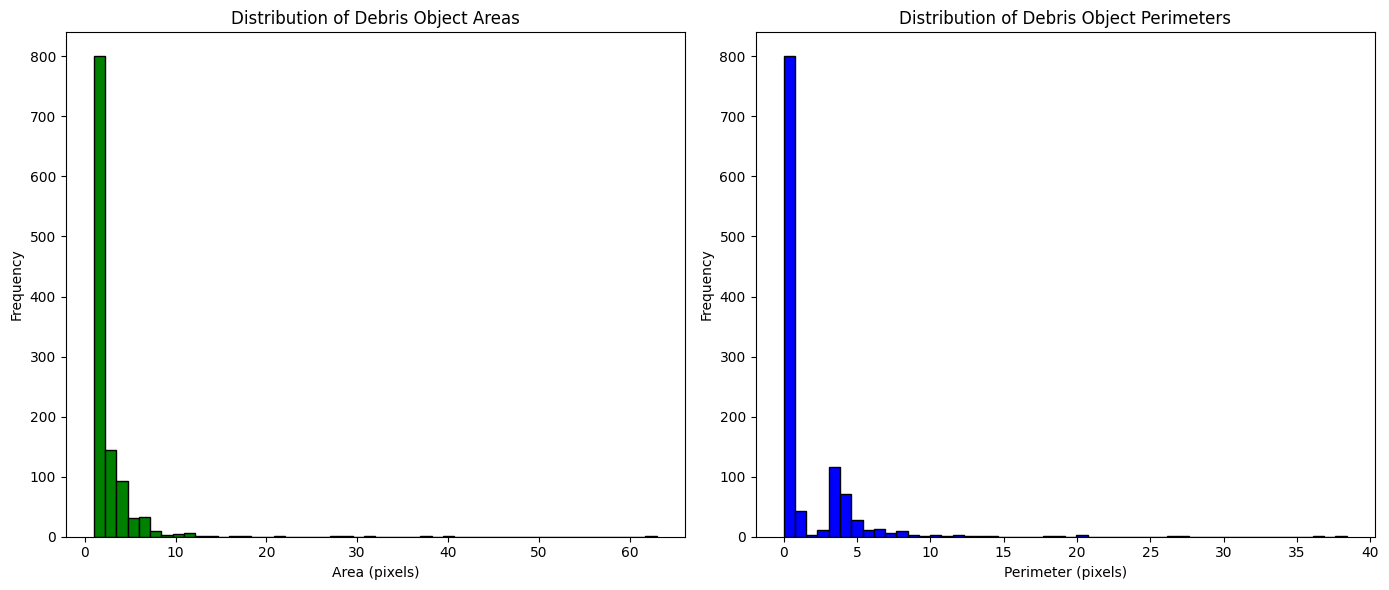

In [ ]:
# Object Size and Shape Analysis

def analyze_object_properties(sample_size=50):
    """Analyze the size and shape of debris objects"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Initialize lists to store object properties
    areas = []
    perimeters = []

    for s2_dir in tqdm(s2_dirs_sample, desc="Analyzing object properties"):
        dir_path = os.path.join(patches_dir, s2_dir)
        mask_files = [f for f in os.listdir(dir_path) if f.endswith('_cl.tif')]

        for mask_file in mask_files:
            mask_path = os.path.join(dir_path, mask_file)
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)

                # Find debris objects (class 1)
                debris_objects = mask_data == 1

                # Label connected components
                from skimage.measure import label, regionprops
                labeled_objects = label(debris_objects)

                # Calculate properties for each object
                for region in regionprops(labeled_objects):
                    areas.append(region.area)
                    perimeters.append(region.perimeter)

    # Plot distributions
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Area distribution
    axs[0].hist(areas, bins=50, color='green', edgecolor='black')
    axs[0].set_title('Distribution of Debris Object Areas')
    axs[0].set_xlabel('Area (pixels)')
    axs[0].set_ylabel('Frequency')

    # Perimeter distribution
    axs[1].hist(perimeters, bins=50, color='blue', edgecolor='black')
    axs[1].set_title('Distribution of Debris Object Perimeters')
    axs[1].set_xlabel('Perimeter (pixels)')
    axs[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "object_properties.png"))
    plt.show()

    return {'areas': areas, 'perimeters': perimeters}

# Execute object properties analysis
object_properties = analyze_object_properties()

In [ ]:
# Data Visualization with Plastic Debris Highlighting

def visualize_data_with_plastic_highlight(sample_size=10):
    """Visualize sample data and highlight plastic debris"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    for s2_dir in tqdm(s2_dirs_sample, desc="Visualizing data"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path)
                       if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                       and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # Create RGB composite for visualization
                rgb = np.stack([img_data[2], img_data[1], img_data[0]], axis=0)  # Assuming R, G, B order
                rgb = np.transpose(rgb, (1, 2, 0))
                rgb_norm = (rgb - np.min(rgb)) / (np.max(rgb) - np.min(rgb))  # Normalize for display

                # Create a mask for plastic debris (class 1)
                plastic_mask = np.zeros_like(mask_data)
                plastic_mask[mask_data == 1] = 1

                # Highlight plastic debris on the image
                highlighted_image = rgb_norm.copy()
                highlighted_image[plastic_mask == 1] = [1, 0, 0]  # Highlight in red

                # Display the image and highlighted image
                fig, axs = plt.subplots(1, 2, figsize=(14, 7))
                axs[0].imshow(rgb_norm)
                axs[0].set_title("Original Image")
                axs[1].imshow(highlighted_image)
                axs[1].set_title("Plastic Debris Highlighted")
                plt.tight_layout()
                plt.show()

visualize_data_with_plastic_highlight(sample_size=10)

Calculating plastic indices:   0%|          | 0/20 [00:00<?, ?it/s]

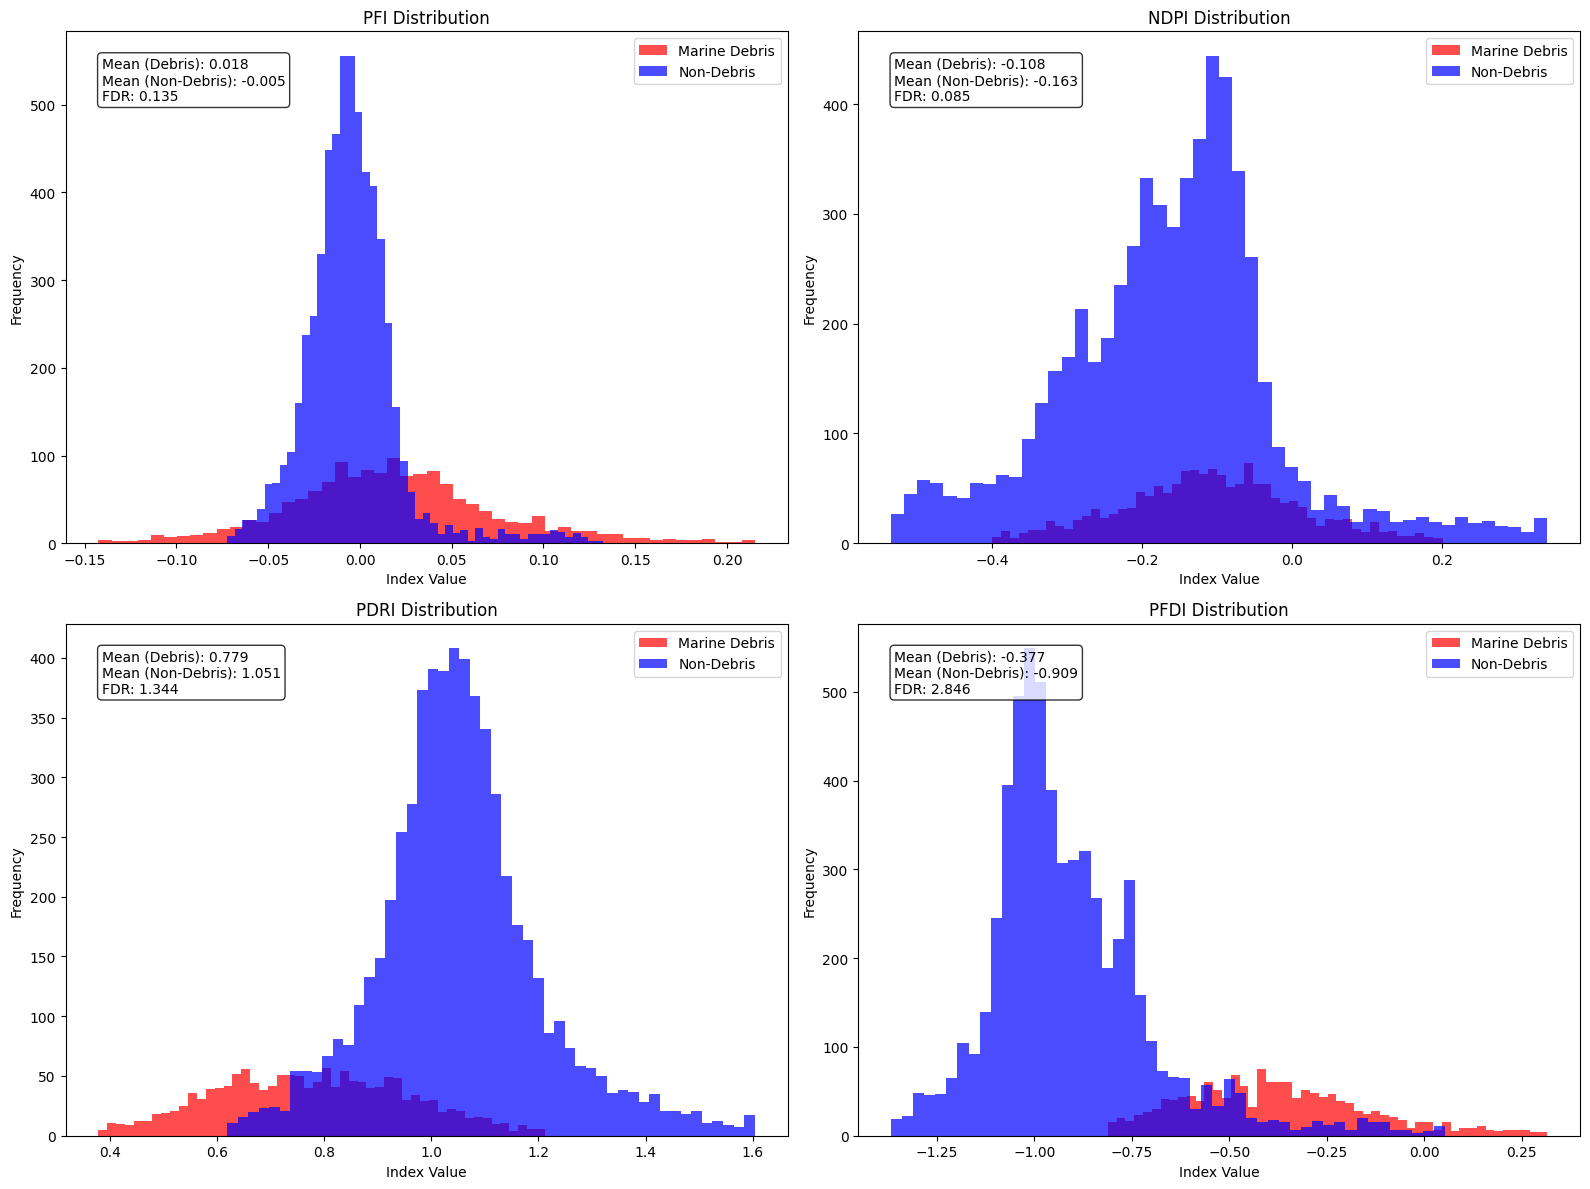

Best plastic debris detection index: PFDI


In [ ]:
# Custom Indices for Plastic Debris

def develop_plastic_indices(sample_size=20):
    """Develop and evaluate custom indices specifically for plastic debris detection"""
    patches_dir = os.path.join(base_dir, "patches")

    # Get list of all S2 date-tile directories
    s2_dirs = [d for d in os.listdir(patches_dir) if os.path.isdir(os.path.join(patches_dir, d))]

    # Randomly sample directories for analysis
    if len(s2_dirs) > sample_size:
        import random
        s2_dirs_sample = random.sample(s2_dirs, sample_size)
    else:
        s2_dirs_sample = s2_dirs

    # Define band indices for common Sentinel-2 bands
    blue_idx = 0    # B2
    green_idx = 1   # B3
    red_idx = 2     # B4
    rededge1_idx = 3  # B5
    rededge2_idx = 4  # B6
    rededge3_idx = 5  # B7
    nir_idx = 6     # B8
    nir2_idx = 7    # B8A
    swir1_idx = 8   # B11
    swir2_idx = 9   # B12

    # Initialize statistics for each index
    index_stats = {
        'PFI': {'debris': [], 'non_debris': []},  # Plastic Float Index
        'NDPI': {'debris': [], 'non_debris': []}, # Normalized Difference Plastic Index
        'PDRI': {'debris': [], 'non_debris': []}, # Plastic Debris Ratio Index
        'PFDI': {'debris': [], 'non_debris': []}  # Plastic Floating Debris Index
    }

    for s2_dir in tqdm(s2_dirs_sample, desc="Calculating plastic indices"):
        dir_path = os.path.join(patches_dir, s2_dir)

        # Find image-mask pairs
        image_files = [f for f in os.listdir(dir_path)
                     if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                     and f.endswith('.tif')]

        for image_file in image_files:
            image_path = os.path.join(dir_path, image_file)
            mask_file = image_file.replace('.tif', '_cl.tif')
            mask_path = os.path.join(dir_path, mask_file)

            if not os.path.exists(mask_path):
                continue

            # Open image and mask
            with rasterio.open(image_path) as img_src, rasterio.open(mask_path) as mask_src:
                img_data = img_src.read()
                mask_data = mask_src.read(1)

                # Extract debris mask
                debris_mask = mask_data == 1
                non_debris_mask = (mask_data > 1) & (mask_data < 16)  # All other valid classes

                # Skip if no debris or non-debris pixels
                if not np.any(debris_mask) or not np.any(non_debris_mask):
                    continue

                # Extract bands
                try:
                    blue = img_data[blue_idx]
                    green = img_data[green_idx]
                    red = img_data[red_idx]
                    rededge1 = img_data[rededge1_idx]
                    nir = img_data[nir_idx]
                    swir1 = img_data[swir1_idx]
                    swir2 = img_data[swir2_idx]
                except IndexError:
                    continue

                # Add small epsilon to avoid division by zero
                eps = 1e-8

                # Calculate custom plastic indices

                # PFI - Plastic Float Index (highlighting floating materials with plastic spectral characteristics)
                pfi = (swir1 - nir) / (swir1 + nir + eps) * (rededge1 / (blue + eps))

                # NDPI - Normalized Difference Plastic Index (targeting specific plastic reflectance features)
                ndpi = (swir1 - red) / (swir1 + red + eps)

                # PDRI - Plastic Debris Ratio Index (ratio-based approach using key bands)
                pdri = (swir1 / (nir + eps)) * (blue / (green + eps))

                # PFDI - Plastic Floating Debris Index (complex index targeting floating plastic)
                pfdi = (swir1 - blue) / (swir1 + blue + eps) * (nir / (red + eps)) - (swir2 / (swir1 + eps))

                # Collect statistics for each index
                indices = {'PFI': pfi, 'NDPI': ndpi, 'PDRI': pdri, 'PFDI': pfdi}

                for index_name, index_values in indices.items():
                    # Sample values (to avoid memory issues with large images)
                    debris_pixels = index_values[debris_mask]
                    if len(debris_pixels) > 1000:
                        debris_pixels = np.random.choice(debris_pixels, 1000, replace=False)

                    non_debris_pixels = index_values[non_debris_mask]
                    if len(non_debris_pixels) > 1000:
                        non_debris_pixels = np.random.choice(non_debris_pixels, 1000, replace=False)

                    index_stats[index_name]['debris'].extend(debris_pixels)
                    index_stats[index_name]['non_debris'].extend(non_debris_pixels)

    # Analyze separation capability of each index
    plt.figure(figsize=(16, 12))

    for i, (index_name, values) in enumerate(index_stats.items()):
        plt.subplot(2, 2, i+1)

        # Convert lists to numpy arrays
        debris_values = np.array(values['debris'])
        non_debris_values = np.array(values['non_debris'])

        # Remove extreme outliers
        debris_q1, debris_q3 = np.percentile(debris_values, [1, 99])
        non_debris_q1, non_debris_q3 = np.percentile(non_debris_values, [1, 99])

        debris_values = debris_values[(debris_values >= debris_q1) & (debris_values <= debris_q3)]
        non_debris_values = non_debris_values[(non_debris_values >= non_debris_q1) & (non_debris_values <= non_debris_q3)]

        # Plot histograms
        plt.hist(debris_values, bins=50, alpha=0.7, label='Marine Debris', color='red')
        plt.hist(non_debris_values, bins=50, alpha=0.7, label='Non-Debris', color='blue')

        plt.title(f"{index_name} Distribution")
        plt.xlabel("Index Value")
        plt.ylabel("Frequency")
        plt.legend()

        # Calculate and display separation metrics
        d_mean = np.mean(debris_values)
        nd_mean = np.mean(non_debris_values)
        d_std = np.std(debris_values)
        nd_std = np.std(non_debris_values)

        # Fisher's Discriminant Ratio (higher is better)
        fdr = ((d_mean - nd_mean) ** 2) / (d_std ** 2 + nd_std ** 2 + eps)

        plt.text(0.05, 0.95, f"Mean (Debris): {d_mean:.3f}\nMean (Non-Debris): {nd_mean:.3f}\nFDR: {fdr:.3f}",
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.savefig(os.path.join(processed_dir, "plastic_indices_evaluation.png"))
    plt.show()

    # Return the index with the highest FDR as the best one
    best_index = max(index_stats.keys(), key=lambda idx:
                   ((np.mean(index_stats[idx]['debris']) - np.mean(index_stats[idx]['non_debris'])) ** 2) /
                   (np.std(index_stats[idx]['debris']) ** 2 + np.std(index_stats[idx]['non_debris']) ** 2 + eps))

    print(f"Best plastic debris detection index: {best_index}")
    return index_stats, best_index

# Execute plastic indices development
plastic_indices_stats, best_plastic_index = develop_plastic_indices()

In [ ]:
# Data Preprocessing for UNeXt Model with restlite encoder Training

import torch
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split

def preprocess_data_for_training():
    """Preprocess MARIDA data for training the Attention U-Net model"""
    patches_dir = os.path.join(base_dir, "patches")
    splits_dir = os.path.join(base_dir, "splits")

    # Create output directory for preprocessed data
    preprocessed_dir = os.path.join(processed_dir, "preprocessed")
    os.makedirs(preprocessed_dir, exist_ok=True)

    # Load splits
    train_paths = []
    val_paths = []
    test_paths = []

    # Check if predefined splits exist
    if os.path.exists(os.path.join(splits_dir, "train_1.txt")):
        print("Using predefined dataset splits...")
        with open(os.path.join(splits_dir, "train_1.txt"), 'r') as f:
            train_paths = [line.strip() for line in f.readlines()]
        with open(os.path.join(splits_dir, "val_1.txt"), 'r') as f:
            val_paths = [line.strip() for line in f.readlines()]
        with open(os.path.join(splits_dir, "test_1.txt"), 'r') as f:
            test_paths = [line.strip() for line in f.readlines()]
    else:
        print("Creating new dataset splits...")
        # Get all image paths
        all_image_paths = []
        for s2_dir in os.listdir(patches_dir):
            dir_path = os.path.join(patches_dir, s2_dir)
            if os.path.isdir(dir_path):
                image_files = [f for f in os.listdir(dir_path)
                            if not f.endswith('_cl.tif') and not f.endswith('_conf.tif')
                            and f.endswith('.tif')]
                for img_file in image_files:
                    # Check if mask exists
                    mask_file = img_file.replace('.tif', '_cl.tif')
                    mask_path = os.path.join(dir_path, mask_file)
                    if os.path.exists(mask_path):
                        all_image_paths.append(os.path.join(s2_dir, img_file))

        # Split data
        train_val_paths, test_paths = train_test_split(all_image_paths, test_size=0.2, random_state=42)
        train_paths, val_paths = train_test_split(train_val_paths, test_size=0.2, random_state=42)

        # Save splits for future use
        os.makedirs(splits_dir, exist_ok=True)
        with open(os.path.join(splits_dir, "train_custom.txt"), 'w') as f:
            f.write('\n'.join(train_paths))
        with open(os.path.join(splits_dir, "val_custom.txt"), 'w') as f:
            f.write('\n'.join(val_paths))
        with open(os.path.join(splits_dir, "test_custom.txt"), 'w') as f:
            f.write('\n'.join(test_paths))

    print(f"Dataset splits: {len(train_paths)} training, {len(val_paths)} validation, {len(test_paths)} test samples")

    # Create metadata files with class frequencies
    analyze_split_class_distribution(train_paths, "train", patches_dir, preprocessed_dir)
    analyze_split_class_distribution(val_paths, "val", patches_dir, preprocessed_dir)
    analyze_split_class_distribution(test_paths, "test", patches_dir, preprocessed_dir)

    # Save paths for DataLoader
    split_paths = {
        'train': train_paths,
        'val': val_paths,
        'test': test_paths
    }

    # Save paths for later use
    with open(os.path.join(preprocessed_dir, "split_paths.pkl"), 'wb') as f:
        import pickle
        pickle.dump(split_paths, f)

    print("Data preprocessing completed and paths saved.")
    return split_paths

def analyze_split_class_distribution(paths, split_name, patches_dir, output_dir):
    """Analyze class distribution in a dataset split"""
    class_counts = {i: 0 for i in range(1, 16)}
    total_pixels = 0
    has_debris_count = 0

    for path in tqdm(paths, desc=f"Analyzing {split_name} split"):
        dir_name = os.path.dirname(path)
        img_name = os.path.basename(path)
        mask_name = img_name.replace('.tif', '_cl.tif')
        mask_path = os.path.join(patches_dir, dir_name, mask_name)

        if os.path.exists(mask_path):
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)

                # Count class pixels
                has_debris = False
                for class_id in range(1, 16):
                    count = np.sum(mask_data == class_id)
                    class_counts[class_id] += count

                    if class_id == 1 and count > 0:
                        has_debris = True

                if has_debris:
                    has_debris_count += 1

                total_pixels += mask_data.size

    # Calculate percentages
    class_percentages = {class_id: (count / total_pixels * 100)
                        for class_id, count in class_counts.items()}

    # Save results
    with open(os.path.join(output_dir, f"{split_name}_class_distribution.txt"), 'w') as f:
        f.write(f"Class distribution in {split_name} split:\n")
        f.write(f"Total images: {len(paths)}\n")
        f.write(f"Images with debris: {has_debris_count} ({has_debris_count/len(paths)*100:.2f}%)\n\n")

        for class_id, percentage in sorted(class_percentages.items(), key=lambda x: x[1], reverse=True):
            f.write(f"{class_id}: {class_mapping[class_id]} - {percentage:.2f}%\n")

    # Calculate class weights (  inverse frequency)
    class_weights = {class_id: (total_pixels / (count + 1))
                   for class_id, count in class_counts.items()}

    # Normalize weights to sum to 1
    sum_weights = sum(class_weights.values())
    normalized_weights = {class_id: weight / sum_weights for class_id, weight in class_weights.items()}

    # Save weights for training
    np.save(os.path.join(output_dir, f"{split_name}_class_weights.npy"),
           np.array([normalized_weights[i] for i in range(1, 16)]))

    return class_percentages

# MARIDA Dataset class
class MARIDADataset(Dataset):
    def __init__(self, paths, patches_dir, transform=None, use_multispectral=True):
        self.paths = paths
        self.patches_dir = patches_dir
        self.transform = transform
        self.use_multispectral = use_multispectral
        self.rgb_bands = [2, 1, 0]  # B4, B3, B2 (0 indexed)

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        try:
            img_path = self.paths[idx]
            dir_name = os.path.dirname(img_path)
            img_name = os.path.basename(img_path)
            full_img_path = os.path.join(self.patches_dir, dir_name, img_name)
            mask_name = img_name.replace('.tif', '_cl.tif')
            full_mask_path = os.path.join(self.patches_dir, dir_name, mask_name)

            with rasterio.open(full_img_path) as src:
                image = src.read()

            with rasterio.open(full_mask_path) as src:
                mask = src.read(1)

            # Ensure mask is binary (0 or 1)
            binary_mask = (mask == 1).astype(np.float32)

            # Rest of the preprocessing...
            if not self.use_multispectral:
                image = image[self.rgb_bands]

            image = image.astype(np.float32)

            # Calculating band ratios and indices that highlight plastics
            if self.use_multispectral:
                nir_band = 3
                red_band = 2
                ndvi = (image[nir_band] - image[red_band]) / (image[nir_band] + image[red_band] + 1e-7)
                image = np.vstack([image, ndvi.reshape(1, image.shape[1], image.shape[2])])

            # Normalizing each band
            for i in range(image.shape[0]):
                band_min, band_max = np.nanmin(image[i]), np.nanmax(image[i])
                if np.isnan(band_min) or np.isnan(band_max):
                    image[i] = np.nan_to_num(image[i], nan=0.0)
                    band_min, band_max = 0, 1

                if band_max > band_min:
                    image[i] = (image[i] - band_min) / (band_max - band_min)
                else:
                    image[i] = np.zeros_like(image[i])

            image = np.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)

            if self.transform:
                transformed = self.transform(image=np.transpose(image, (1, 2, 0)), mask=binary_mask)
                image = transformed['image']
                binary_mask = transformed['mask']

                if not torch.is_tensor(image):
                    image = torch.from_numpy(image.transpose(2, 0, 1))
                if not torch.is_tensor(binary_mask):
                    binary_mask = torch.from_numpy(binary_mask).unsqueeze(0)
            else:
                image = torch.from_numpy(image)
                binary_mask = torch.from_numpy(binary_mask).unsqueeze(0)

            return image, binary_mask

        except Exception as e:
            print(f"Error loading sample {idx}: {e}")
            if self.use_multispectral:
                dummy_img = torch.zeros((12, 256, 256), dtype=torch.float32)
            else:
                dummy_img = torch.zeros((3, 256, 256), dtype=torch.float32)
            dummy_mask = torch.zeros((1, 256, 256), dtype=torch.float32)
            return dummy_img, dummy_mask

# Defining training transform with augmentation
train_transform = A.Compose([
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(p=0.3),  # Add elastic transform
    A.GridDistortion(p=0.2),    # Add grid distortion
    A.OpticalDistortion(p=0.2), # Add optical distortion
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.OneOf([  # Add one of these channel-specific augmentations
        A.RandomGamma(p=1.0),
        A.ChannelShuffle(p=1.0),  # its good for multispectral data
        A.ChannelDropout(p=1.0),  # it randomly drop channels
    ], p=0.3),
    ToTensorV2()
])

# Define validation transform (no augmentation, justnormalization)
val_transform = A.Compose([
    ToTensorV2()  # itsonly convert to tensor, no augmentation
])

def prepare_data_loaders(split_paths, patches_dir, batch_size=8, num_workers=4, use_multispectral=True):
    # Calculate sample weights - more weight for samples with debris
    sample_weights = []
    for path in split_paths['train']:
        dir_name = os.path.dirname(path)
        img_name = os.path.basename(path)
        mask_name = img_name.replace('.tif', '_cl.tif')
        mask_path = os.path.join(patches_dir, dir_name, mask_name)

        with rasterio.open(mask_path) as src:
            mask = src.read(1)
            has_debris = (mask == 1).any()
            weight = 3.0 if has_debris else 1.0  # Higher weight for debris samples
            sample_weights.append(weight)

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(split_paths['train']),
        replacement=True
    )

    # Create datasets
    train_dataset = MARIDADataset(
        split_paths['train'],
        patches_dir,
        transform=train_transform,  # Useing train_transform
        use_multispectral=use_multispectral
    )

    val_dataset = MARIDADataset(
        split_paths['val'],
        patches_dir,
        transform=val_transform,  # Useing val_transform
        use_multispectral=use_multispectral
    )

    test_dataset = MARIDADataset(
        split_paths['test'],
        patches_dir,
        transform=val_transform,  # Useing val_transform for test as well
        use_multispectral=use_multispectral
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Testing samples: {len(test_dataset)}")
    sample_img, _ = train_dataset[0]
    print(f"Input image shape: {sample_img.shape}")
    print(f"Using {'multispectral' if use_multispectral else 'RGB'} data")

    return train_loader, val_loader, test_loader

# Execute data preprocessing
split_paths = preprocess_data_for_training()
train_loader, val_loader, test_loader = prepare_data_loaders(
    split_paths,
    os.path.join(base_dir, "patches"),
    batch_size=8,
    use_multispectral=True  # Set to True for multispectral approach
)

Creating new dataset splits...
Dataset splits: 883 training, 221 validation, 277 test samples


Analyzing test split: 100%|██████████| 277/277 [00:00<00:00, 388.14it/s]


Data preprocessing completed and paths saved.
Training samples: 883
Validation samples: 221
Testing samples: 277
Input image shape: torch.Size([12, 256, 256])
Using multispectral data


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import time
import copy
import os
from tqdm import tqdm
import math
from functools import partial
from timm.models.layers import DropPath, trunc_normal_

# ResT-Lite Component Implementations
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divisible by num_heads {num_heads}"

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)

        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class PatchEmbed(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = (img_size, img_size) if isinstance(img_size, int) else img_size
        patch_size = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size
        H, W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = H, W
        self.num_patches = H * W

        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x).flatten(2).transpose(1, 2)
        x = self.norm(x)
        H, W = H // self.patch_size[0], W // self.patch_size[1]
        return x, (H, W)

class ResTLite(nn.Module):
    """ResT-Lite backbone implementation for UNeXt model"""
    def __init__(self, in_chans=3, depths=[2, 2, 2, 2], embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=True,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., sr_ratios=[8, 4, 2, 1],
                 norm_layer=partial(nn.LayerNorm, eps=1e-6)):
        super().__init__()
        self.depths = depths
        self.num_stages = len(depths)

        # Patch embeddings
        self.patch_embed1 = PatchEmbed(img_size=256, patch_size=4, in_chans=in_chans, embed_dim=embed_dims[0])
        self.patch_embed2 = PatchEmbed(img_size=64, patch_size=2, in_chans=embed_dims[0], embed_dim=embed_dims[1])
        self.patch_embed3 = PatchEmbed(img_size=32, patch_size=2, in_chans=embed_dims[1], embed_dim=embed_dims[2])
        self.patch_embed4 = PatchEmbed(img_size=16, patch_size=2, in_chans=embed_dims[2], embed_dim=embed_dims[3])

        # Transformer blocks
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        cur = 0

        self.block1 = nn.ModuleList([
            Block(dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias,
                  drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur+i], sr_ratio=sr_ratios[0],
                  norm_layer=norm_layer) for i in range(depths[0])
        ])
        self.norm1 = norm_layer(embed_dims[0])
        cur += depths[0]

        self.block2 = nn.ModuleList([
            Block(dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias,
                  drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur+i], sr_ratio=sr_ratios[1],
                  norm_layer=norm_layer) for i in range(depths[1])
        ])
        self.norm2 = norm_layer(embed_dims[1])
        cur += depths[1]

        self.block3 = nn.ModuleList([
            Block(dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias,
                  drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur+i], sr_ratio=sr_ratios[2],
                  norm_layer=norm_layer) for i in range(depths[2])
        ])
        self.norm3 = norm_layer(embed_dims[2])
        cur += depths[2]

        self.block4 = nn.ModuleList([
            Block(dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias,
                  drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur+i], sr_ratio=sr_ratios[3],
                  norm_layer=norm_layer) for i in range(depths[3])
        ])
        self.norm4 = norm_layer(embed_dims[3])

        # Weights initialization
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward_features(self, x):
        features = []
        B = x.shape[0]

        # Stage 1
        x, (H, W) = self.patch_embed1(x)
        for blk in self.block1:
            x = blk(x, H, W)
        x = self.norm1(x)
        x1 = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        features.append(x1)

        # Stage 2
        x, (H, W) = self.patch_embed2(x1)
        for blk in self.block2:
            x = blk(x, H, W)
        x = self.norm2(x)
        x2 = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        features.append(x2)

        # Stage 3
        x, (H, W) = self.patch_embed3(x2)
        for blk in self.block3:
            x = blk(x, H, W)
        x = self.norm3(x)
        x3 = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        features.append(x3)

        # Stage 4
        x, (H, W) = self.patch_embed4(x3)
        for blk in self.block4:
            x = blk(x, H, W)
        x = self.norm4(x)
        x4 = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        features.append(x4)

        return features

    def forward(self, x):
        return self.forward_features(x)

# UNeXt model components - Fixed ConvNextBlock
class ConvNextBlock(nn.Module):
    def __init__(self, dim, dim_out, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim)
        self.pwconv1 = nn.Linear(dim, 4 * dim)
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim_out)

        # Add projection layer if dimensions change
        self.proj = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim_out)),
                                requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input_x = x
        B, C, H, W = x.shape

        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = x * self.gamma

        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        # Apply projection to input if dimensions differ
        input_x = self.proj(input_x)

        # Apply drop path and add residual
        x = input_x + self.drop_path(x)

        return x

# Fixed Decoder class
class Decoder(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels, drop_path=0.):
        super().__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )

        # Calculate combined channels after concatenation
        combined_channels = out_channels + (skip_channels if skip_channels > 0 else 0)

        self.conv = ConvNextBlock(combined_channels, out_channels, drop_path=drop_path)

    def forward(self, x, skip=None):
        x = self.up(x)

        if skip is not None:
            # this helps to handle different spatial dimensions
            if x.shape[2] != skip.shape[2] or x.shape[3] != skip.shape[3]:
                x = F.interpolate(x, size=(skip.shape[2], skip.shape[3]),
                                 mode='bilinear', align_corners=True)

            # Concatenate skip connection
            x = torch.cat([x, skip], dim=1)

        x = self.conv(x)
        return x

class UNeXt(nn.Module):
    def __init__(self, in_channels=12, out_channels=1,
                backbone_dims=[64, 128, 256, 512], drop_path_rate=0.1):
        super().__init__()
        # ResT-Lite backbone
        self.backbone = ResTLite(in_chans=in_channels, embed_dims=backbone_dims)

        # Decoder path with proper channel alignment
        drop_path_values = torch.linspace(0, drop_path_rate, 4).tolist()

        # Initialize decoders with correct channel sizes
        self.decoder1 = Decoder(backbone_dims[3], backbone_dims[2], backbone_dims[2], drop_path_values[0])
        self.decoder2 = Decoder(backbone_dims[2], backbone_dims[1], backbone_dims[1], drop_path_values[1])
        self.decoder3 = Decoder(backbone_dims[1], backbone_dims[0], backbone_dims[0], drop_path_values[2])
        self.decoder4 = Decoder(backbone_dims[0], 0, backbone_dims[0]//2, drop_path_values[3])

        # Final convolution
        self.final_conv = nn.Sequential(
            nn.Conv2d(backbone_dims[0]//2, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, kernel_size=1)
        )

        # Add an upsampling layer to ensure output resolution matches input
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Store original spatial dimensions
        _, _, H, W = x.shape

        # Get features from backbone
        features = self.backbone(x)

        # Apply decoders
        x = self.decoder1(features[3], features[2])
        x = self.decoder2(x, features[1])
        x = self.decoder3(x, features[0])
        x = self.decoder4(x)

        # Apply final convolution
        x = self.final_conv(x)

        # Ensure output resolution matches input resolution
        if x.shape[2] != H or x.shape[3] != W:
            x = F.interpolate(x, size=(H, W), mode='bilinear', align_corners=True)

        return torch.sigmoid(x)

# Loss Functions
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weight=10.0):
        super().__init__()
        self.pos_weight = pos_weight

    def forward(self, pred, target):
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        # Binary cross entropy with weights, maintaining batch dimensions
        pred_sigmoid = torch.clamp(pred, min=1e-7, max=1.0-1e-7)
        loss = -self.pos_weight * target * torch.log(pred_sigmoid) - (1 - target) * torch.log(1 - pred_sigmoid)
        return loss.mean()

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.9, gamma=3.5):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = 1e-7

    def forward(self, pred, target):
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        pred = torch.clamp(pred, min=self.eps, max=1.0 - self.eps)
        bce_loss = -target * torch.log(pred) - (1 - target) * torch.log(1 - pred)
        pt = torch.exp(-bce_loss)
        focal_weight = (1 - pt) ** self.gamma
        alpha_weight = target * self.alpha + (1 - target) * (1 - self.alpha)
        focal_weight = alpha_weight * focal_weight
        return (focal_weight * bce_loss).mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Make sure target has same shape as predictions
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        # Flatten predictions and targets properly
        batch_size = pred.size(0)
        pred_flat = pred.view(batch_size, -1)
        target_flat = target.view(batch_size, -1)

        # Calculate Dice score per batch and then mean
        intersection = (pred_flat * target_flat).sum(dim=1)
        union = pred_flat.sum(dim=1) + target_flat.sum(dim=1)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice.mean()

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, pred, target):
        # Make sure target has same shape as predictions
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        # Flatten predictions and targets properly
        batch_size = pred.size(0)
        pred_flat = pred.view(batch_size, -1)
        target_flat = target.view(batch_size, -1)

        # True Positive, False Negative, False Positive
        TP = (pred_flat * target_flat).sum(dim=1)
        FN = ((1 - pred_flat) * target_flat).sum(dim=1)
        FP = (pred_flat * (1 - target_flat)).sum(dim=1)

        # Tversky index
        tversky = (TP + self.smooth) / (TP + self.alpha * FN + self.beta * FP + self.smooth)

        return 1 - tversky.mean()

class LovaszLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred, target):
        # Make sure target has same shape as predictions
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        # Handle batch dimension - process each sample separately
        batch_size = pred.size(0)
        losses = []

        for i in range(batch_size):
            pred_sample = pred[i].view(-1)
            target_sample = target[i].view(-1)

            # Sort predictions by error
            errors = torch.abs(target_sample - pred_sample)
            perm = torch.argsort(errors, dim=0, descending=True)
            pred_sorted = pred_sample[perm]
            target_sorted = target_sample[perm]

            # Calculate IoU at each threshold
            intersection = target_sorted.cumsum(0)
            union = target_sorted.sum() + (1 - target_sorted).cumsum(0)
            iou = 1 - (intersection / (union + 1e-5))

            # Get gradients
            grad = torch.cat((torch.ones_like(iou[:1]), iou[1:] - iou[:-1]))

            # Calculate final loss
            sample_loss = (grad * errors[perm]).sum()
            losses.append(sample_loss)

        return torch.stack(losses).mean()

# Generalized IoU Loss
class GeneralizedIoULoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        # Make sure target has same shape as predictions
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        # Handle batch dimension properly
        batch_size = pred.size(0)
        pred_flat = pred.view(batch_size, -1)
        target_flat = target.view(batch_size, -1)

        # Calculate intersection and union per batch item
        intersection = (pred_flat * target_flat).sum(dim=1)
        union = pred_flat.sum(dim=1) + target_flat.sum(dim=1) - intersection

        # Calculate IoU
        iou = (intersection + self.smooth) / (union + self.smooth)

        # Calculate the enclosing box (in this 1D case, it's just the max of pred and target)
        enclosed_area = torch.max(pred_flat, target_flat).sum(dim=1)

        # Calculate GIoU
        giou = iou - (enclosed_area - union) / (enclosed_area + self.smooth)

        return 1 - giou.mean()

# Combined Loss Function
class CombinedSegLoss(nn.Module):
    def __init__(self, dice_weight=0.3, focal_weight=0.2, tversky_weight=0.2,
                 lovasz_weight=0.15, giou_weight=0.15, wce_weight=0.0, pos_weight=10.0):
        super().__init__()
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        self.tversky_weight = tversky_weight
        self.lovasz_weight = lovasz_weight
        self.giou_weight = giou_weight
        self.wce_weight = wce_weight

        # Initialize individual losses
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss(alpha=0.9, gamma=3.5)
        self.tversky_loss = TverskyLoss(alpha=0.7, beta=0.3)
        self.lovasz_loss = LovaszLoss()
        self.giou_loss = GeneralizedIoULoss()
        self.wce_loss = WeightedCrossEntropyLoss(pos_weight=pos_weight)

    def forward(self, pred, target):
        # Ensure target has same shape as predictions
        if pred.dim() == 4 and target.dim() == 3:
            target = target.unsqueeze(1)

        # Make sure spatial dimensions match
        if pred.shape[2:] != target.shape[2:]:
            target = F.interpolate(target, size=pred.shape[2:], mode='nearest')

        losses = {
            'dice': self.dice_loss(pred, target) * self.dice_weight,
            'focal': self.focal_loss(pred, target) * self.focal_weight,
            'tversky': self.tversky_loss(pred, target) * self.tversky_weight,
            'lovasz': self.lovasz_loss(pred, target) * self.lovasz_weight,
            'giou': self.giou_loss(pred, target) * self.giou_weight
        }

        # add WCE if the weight is non-zero
        if self.wce_weight > 0:
            losses['wce'] = self.wce_loss(pred, target) * self.wce_weight

        # Return the sum of all losses
        return sum(losses.values())

# Model training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                num_epochs=50, device='cuda', save_dir='models'):
    # Create directory for saving model
    os.makedirs(save_dir, exist_ok=True)

    # Initialize best model and metrics
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    best_dice = 0.0

    # Initialize history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': []
    }

    # Training loop
    start_time = time.time()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 20)

        # Training phase
        model.train()
        running_loss = 0.0
        batch_count = 0

        train_bar = tqdm(train_loader, desc='Training', unit='batch', leave=False)
        for inputs, targets in train_bar:
            try:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(True):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # Backward pass and optimize
                    loss.backward()
                    optimizer.step()

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                batch_count += 1
                train_bar.set_postfix({'loss': loss.item()})

            except Exception as e:
                print(f"Error in training batch: {e}")
                continue

        if batch_count > 0:
            epoch_train_loss = running_loss / (batch_count * train_loader.batch_size)
            history['train_loss'].append(epoch_train_loss)
        else:
            print("Warning: No valid batches in this epoch")
            epoch_train_loss = float('inf')
            history['train_loss'].append(epoch_train_loss)

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_dice = 0.0
        val_batch_count = 0

        val_bar = tqdm(val_loader, desc='Validation', unit='batch', leave=False)
        for inputs, targets in val_bar:
            try:
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                with torch.no_grad():
                    outputs = model(inputs)

                    # Ensure outputs have the same spatial dimensions as targets
                    if outputs.shape[2:] != targets.shape[1:]:  # targets might be [B, H, W]
                        outputs = F.interpolate(outputs, size=targets.shape[1:], mode='bilinear', align_corners=True)

                    loss = criterion(outputs, targets)

                    # Ensure targets have same dimension as predictions
                    if outputs.dim() == 4 and targets.dim() == 3:
                        targets = targets.unsqueeze(1)

                    # Calculate Dice score (for monitoring)
                    preds = (outputs > 0.5).float()
                    intersection = (preds * targets).sum()
                    dice = (2.0 * intersection + 1e-5) / (preds.sum() + targets.sum() + 1e-5)

                # Update statistics
                running_loss += loss.item() * inputs.size(0)
                running_dice += dice.item() * inputs.size(0)
                val_batch_count += 1
                val_bar.set_postfix({'loss': loss.item(), 'dice': dice.item()})

            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue

        if val_batch_count > 0:
            epoch_val_loss = running_loss / (val_batch_count * val_loader.batch_size)
            epoch_val_dice = running_dice / (val_batch_count * val_loader.batch_size)
            history['val_loss'].append(epoch_val_loss)
            history['val_dice'].append(epoch_val_dice)
        else:
            print("Warning: No valid batches in validation")
            epoch_val_loss = float('inf')
            epoch_val_dice = 0.0
            history['val_loss'].append(epoch_val_loss)
            history['val_dice'].append(epoch_val_dice)

        # Update learning rate
        scheduler.step(epoch_val_loss)

        # Check if this is the best model
        if epoch_val_dice > best_dice:
            best_dice = epoch_val_dice
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # Save best model
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'dice': best_dice,
                'history': history
            }, os.path.join(save_dir, 'best_model.pth'))

        # Print epoch results
        print(f'Train Loss: {epoch_train_loss:.4f}')
        print(f'Validation Loss: {epoch_val_loss:.4f}, Dice: {epoch_val_dice:.4f}')
        print(f'Best Validation Dice: {best_dice:.4f}')

        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': epoch_val_loss,
                'dice': epoch_val_dice,
                'history': history
            }, os.path.join(save_dir, f'checkpoint_epoch_{epoch+1}.pth'))

    # Calculate total training time
    time_elapsed = time.time() - start_time
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation Dice: {best_dice:.4f}')

    # Load best model
    model.load_state_dict(best_model_wts)

    return model, history

# Model evaluation function
def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model on test set"""
    model.eval()

    running_dice = 0.0
    running_iou = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_lovasz = 0.0

    lovasz_loss = LovaszLoss()
    test_bar = tqdm(test_loader, desc='Evaluation')

    with torch.no_grad():
        for inputs, targets in test_bar:
            inputs = inputs.to(device)
            targets = targets.to(device).float()

            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            # Calculate metrics
            intersection = (preds * targets).sum().item()
            union = preds.sum().item() + targets.sum().item() - intersection

            # Avoid division by zero
            if union > 0:
                iou = intersection / union
            else:
                iou = 1.0

            if preds.sum().item() > 0:
                precision = intersection / preds.sum().item()
            else:
                precision = 0.0

            if targets.sum().item() > 0:
                recall = intersection / targets.sum().item()
            else:
                recall = 1.0

            # F1 score
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0.0

            # Dice score (same as F1 for binary segmentation)
            dice = 2 * intersection / (preds.sum().item() + targets.sum().item() + 1e-5)

            # Lovasz loss
            lovasz = lovasz_loss(outputs, targets).item()

            # Update statistics
            running_dice += dice * inputs.size(0)
            running_iou += iou * inputs.size(0)
            running_precision += precision * inputs.size(0)
            running_recall += recall * inputs.size(0)
            running_f1 += f1 * inputs.size(0)
            running_lovasz += lovasz * inputs.size(0)

            # Update progress bar
            test_bar.set_postfix({
                'Dice': dice,
                'IoU': iou,
                'Precision': precision,
                'Recall': recall
            })

    # Calculate average metrics
    avg_dice = running_dice / len(test_loader.dataset)
    avg_iou = running_iou / len(test_loader.dataset)
    avg_precision = running_precision / len(test_loader.dataset)
    avg_recall = running_recall / len(test_loader.dataset)
    avg_f1 = running_f1 / len(test_loader.dataset)
    avg_lovasz = running_lovasz / len(test_loader.dataset)

    # Print evaluation results
    print("\nTest metrics:")
    print(f"Dice score: {avg_dice:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 score: {avg_f1:.4f}")
    print(f"Lovasz loss: {avg_lovasz:.4f}")

    # Save metrics to file
    metrics = {
        'dice': avg_dice,
        'iou': avg_iou,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1,
        'lovasz': avg_lovasz
    }

    return metrics

# Prediction function
def predict(model, image, device='cuda'):
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image.unsqueeze(0))
        pred = (output > 0.5).float()
    return pred.squeeze(0).cpu().numpy()

In [ ]:
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define hyperparameters
    BATCH_SIZE = 8
    NUM_EPOCHS = 60
    LEARNING_RATE = 1e-4
    USE_MULTISPECTRAL = True

    # Set model output directory
    model_dir = os.path.join(processed_dir, "models")
    os.makedirs(model_dir, exist_ok=True)

    try:
        # First, prepare the data and create datasets
        split_paths = preprocess_data_for_training()
        train_loader, val_loader, test_loader = prepare_data_loaders(
            split_paths,
            os.path.join(base_dir, "patches"),
            batch_size=BATCH_SIZE,
            use_multispectral=USE_MULTISPECTRAL
        )

        # nOw we can access the dataset through the data loader
        # Get a sample from the training dataset to determine input channels
        sample_img = None
        for sample_batch in train_loader:
            sample_img, _ = sample_batch
            in_channels = sample_img.shape[1]  # Shape is [batch_size, channels, height, width]
            print(f"Using {in_channels} input channels for the model")
            break

        if sample_img is None:
            raise ValueError("No valid samples found in the training dataset")

        # Initialize model with the correct number of input channels
        model = UNeXt(in_channels=12, out_channels=1)
        model = model.to(device)

        # Initialize loss function
        criterion = CombinedSegLoss(
            dice_weight=0.3,
            focal_weight=0.2,
            tversky_weight=0.2,
            lovasz_weight=0.2,
            giou_weight=0.1,
            wce_weight=0.0,
            pos_weight=10.0  # I added pos_weight for class imbalance thinking it might help
        )

        # Initialize optimizer and scheduler
        optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

        # Move model to device safely
        model = model.to(device)
        print("Model successfully moved to device")

        # Train model
        print(f"\nStarting model training for {NUM_EPOCHS} epochs...")
        model, history = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=NUM_EPOCHS,
            device=device,
            save_dir=model_dir
        )

        # Evaluate model on test set
        print("\nEvaluating model on test set...")
        metrics = evaluate_model(model, test_loader, device=device)

        # Save metrics
        with open(os.path.join(model_dir, "test_metrics.json"), 'w') as f:
            import json
            json.dump(metrics, f, indent=4)

        print("\nTraining and evaluation completed!")

    except Exception as e:
        print(f"Error occurred: {e}")
        import traceback
        traceback.print_exc()

Using device: cuda
Creating new dataset splits...
Dataset splits: 883 training, 221 validation, 277 test samples


Analyzing test split: 100%|██████████| 277/277 [00:00<00:00, 380.91it/s]


Data preprocessing completed and paths saved.
Training samples: 883
Validation samples: 221
Testing samples: 277
Input image shape: torch.Size([12, 256, 256])
Using multispectral data
Using 12 input channels for the model
Model successfully moved to device

Starting model training for 60 epochs...

Epoch 1/60
--------------------


Train Loss: 0.4799
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 2/60
--------------------


Train Loss: 0.3643
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 3/60
--------------------


Train Loss: 0.3613
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 4/60
--------------------


Train Loss: 0.3488
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 5/60
--------------------


Train Loss: 0.3622
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 6/60
--------------------


Train Loss: 0.3554
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 7/60
--------------------


Train Loss: 0.3515
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 8/60
--------------------


Train Loss: 0.3522
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 9/60
--------------------


Train Loss: 0.3671
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 10/60
--------------------


Train Loss: 0.3621
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 11/60
--------------------


Train Loss: 0.3268
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 12/60
--------------------


Train Loss: 0.3603
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 13/60
--------------------


Train Loss: 0.3623
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 14/60
--------------------


Train Loss: 0.3499
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 15/60
--------------------


Train Loss: 0.3618
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 16/60
--------------------


Train Loss: 0.3545
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 17/60
--------------------


Train Loss: 0.3434
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 18/60
--------------------


Train Loss: 0.3520
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 19/60
--------------------


Train Loss: 0.3719
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 20/60
--------------------


Train Loss: 0.3454
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 21/60
--------------------


Train Loss: 0.3431
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 22/60
--------------------


Train Loss: 0.3482
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 23/60
--------------------


Train Loss: 0.3520
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 24/60
--------------------


Train Loss: 0.3580
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 25/60
--------------------


Train Loss: 0.3537
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 26/60
--------------------


Train Loss: 0.3608
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 27/60
--------------------


Train Loss: 0.3350
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 28/60
--------------------


Train Loss: 0.3549
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 29/60
--------------------


Train Loss: 0.3350
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 30/60
--------------------


Train Loss: 0.3533
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 31/60
--------------------


Train Loss: 0.3741
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 32/60
--------------------


Train Loss: 0.3596
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 33/60
--------------------


Train Loss: 0.3429
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 34/60
--------------------


Train Loss: 0.3445
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 35/60
--------------------


Train Loss: 0.3500
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 36/60
--------------------


Train Loss: 0.3522
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 37/60
--------------------


Train Loss: 0.3509
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 38/60
--------------------


Train Loss: 0.3389
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 39/60
--------------------


Train Loss: 0.3511
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 40/60
--------------------


Train Loss: 0.3544
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 41/60
--------------------


Train Loss: 0.3387
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 42/60
--------------------


Train Loss: 0.3423
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 43/60
--------------------


Train Loss: 0.3371
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 44/60
--------------------


Train Loss: 0.3364
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 45/60
--------------------


Train Loss: 0.3517
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 46/60
--------------------


Train Loss: 0.3538
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 47/60
--------------------


Train Loss: 0.3488
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 48/60
--------------------


Train Loss: 0.3512
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 49/60
--------------------


Train Loss: 0.3477
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 50/60
--------------------


Train Loss: 0.3593
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 51/60
--------------------


Train Loss: 0.3557
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 52/60
--------------------


Train Loss: 0.3232
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 53/60
--------------------


Train Loss: 0.3586
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 54/60
--------------------


Train Loss: 0.3717
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 55/60
--------------------


Train Loss: 0.3559
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 56/60
--------------------


Train Loss: 0.3636
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 57/60
--------------------


Train Loss: 0.3306
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 58/60
--------------------


Train Loss: 0.3607
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 59/60
--------------------


Train Loss: 0.3292
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Epoch 60/60
--------------------


Train Loss: 0.3532
Validation Loss: 0.2120, Dice: 0.0357
Best Validation Dice: 0.0357

Training complete in 40m 17s
Best validation Dice: 0.0357

Evaluating model on test set...


Evaluation: 100%|██████████| 35/35 [00:07<00:00,  4.48it/s, Dice=0, IoU=0, Precision=0, Recall=0]


Test metrics:
Dice score: 0.0000
IoU: 0.1733
Precision: 0.0000
Recall: 0.1733
F1 score: 0.0000
Lovasz loss: 0.0798

Training and evaluation completed!


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'attention_unet_plastic_debris_pytorch.pth')
print("PyTorch model trained and saved.")

PyTorch model trained and saved.


Evaluating: 100%|██████████| 35/35 [00:09<00:00,  3.78it/s]



Test metrics:
Accuracy: 100.00%
Dice score: 0.0000
IoU: 0.1733
Precision: 0.0000
Recall: 0.1733
F1 score: 0.0000
Lovasz loss: 0.0798


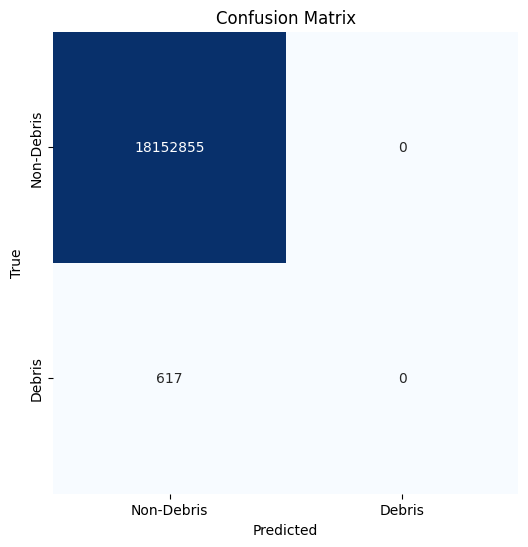

ValueError: too many values to unpack (expected 2)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import torch

def evaluate_model(model, test_loader, device='cuda'):
    """Evaluate model on test set and generate confusion matrix"""
    model.eval()
    y_true = []
    y_pred = []
    running_dice = 0.0
    running_iou = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    running_lovasz = 0.0

    lovasz_loss = LovaszLoss()

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            targets = targets.to(device).float()  # Ensure targets are float for loss calculations

            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()  # Threshold predictions at 0.5

            # Flatten tensors for confusion matrix
            y_true.extend(targets.cpu().numpy().flatten())
            y_pred.extend(preds.cpu().numpy().flatten())

            # Calculate metrics
            intersection = (preds * targets).sum().item()
            union = preds.sum().item() + targets.sum().item() - intersection

            # Avoid division by zero
            if union > 0:
                iou = intersection / union
            else:
                iou = 1.0

            if preds.sum().item() > 0:
                precision = intersection / preds.sum().item()
            else:
                precision = 0.0

            if targets.sum().item() > 0:
                recall = intersection / targets.sum().item()
            else:
                recall = 1.0

            # F1 score
            if precision + recall > 0:
                f1 = 2 * precision * recall / (precision + recall)
            else:
                f1 = 0.0

            # Dice score (same as F1 for binary segmentation)
            dice = 2 * intersection / (preds.sum().item() + targets.sum().item() + 1e-5)

            # Lovasz loss
            lovasz = lovasz_loss(outputs, targets).item()

            # Update statistics
            running_dice += dice * inputs.size(0)
            running_iou += iou * inputs.size(0)
            running_precision += precision * inputs.size(0)
            running_recall += recall * inputs.size(0)
            running_f1 += f1 * inputs.size(0)
            running_lovasz += lovasz * inputs.size(0)

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate average metrics
    avg_dice = running_dice / len(test_loader.dataset)
    avg_iou = running_iou / len(test_loader.dataset)
    avg_precision = running_precision / len(test_loader.dataset)
    avg_recall = running_recall / len(test_loader.dataset)
    avg_f1 = running_f1 / len(test_loader.dataset)
    avg_lovasz = running_lovasz / len(test_loader.dataset)

    # Print evaluation results
    print("\nTest metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Dice score: {avg_dice:.4f}")
    print(f"IoU: {avg_iou:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")
    print(f"F1 score: {avg_f1:.4f}")
    print(f"Lovasz loss: {avg_lovasz:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Debris', 'Debris'],
                yticklabels=['Non-Debris', 'Debris'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Return metrics
    metrics = {
        'accuracy': accuracy,
        'dice': avg_dice,
        'iou': avg_iou,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1': avg_f1,
        'lovasz': avg_lovasz,
        'confusion_matrix': cm
    }

    return metrics


def visualize_predictions(model, test_loader, device='cuda', num_samples=5):
    """Visualize model predictions on test data"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            if i >= num_samples:
                break

            inputs = inputs.to(device)
            targets = targets.to(device).float()

            # Forward pass
            outputs = model(inputs)
            preds = (outputs > 0.5).float()

            # Move tensors to CPU for visualization
            inputs = inputs.cpu().numpy()
            targets = targets.cpu().numpy()
            preds = preds.cpu().numpy()

            # Plot input image (RGB bands)
            axes[i, 0].imshow(inputs[0][:3].transpose(1, 2, 0))  # First 3 channels as RGB
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')

            # Plot ground truth
            axes[i, 1].imshow(targets[0].squeeze(), cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            # Plot predictions
            axes[i, 2].imshow(preds[0].squeeze(), cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


# Evaluate the model
cm, accuracy = evaluate_model(model, test_loader, device='cuda')

# Visualize predictions
visualize_predictions(model, test_loader, device=device, num_samples=5)